# Разработка модели МО для прогнозирования удоя и вкуса молока для управления рисками и принятия объективного решения о покупке

**Цель проекта** - разработать для фермера модель МО для прогнозирования удоя и вкуса молока для управления рисками и принятия объективного решения о покупке коров (на основе данных от одного из поставщиков коров). 

**План:** 

1. Загрузка данных. 
    
    *из файлов:* 
    * ferma_main.csv - данные о стаде фермера на текущий момент; 
    * ferma_dad.csv - данные об имени папы каждой коровы в стаде фермера; 
    * cow_buy.csv - данные о коровах, из числа которых планируется отобрать и приобрести коров. 



2. Предобработка данных: 
* корректировка формата названий столбцов, 
* приведение к корректным типам данных, 
* обработка пропусков, 
* проверка дубликатов. 



3. Статистический анализ данных: 
* анализ всех признаков и построение для них графиков, 
* описание оценки данных (выбросы, распределение и т.д.) и плана по их улучшению. 



4. Корреляционный анализ (данных из файла ferma_main.csv): 
* оценка корреляции между признаками, 
* построение диаграмм рассеивания для "Удой, кг" и количественных признаков (с учётом значения категориальных признаков), 
* выводы о взаимосвязи признаков. 



5. Задача регрессии - прогноз объема молока
* обучение первой модели, 
* обучение второй модели, 
* обучение третьей модели, 
* сравнение качества моделей по показателям, 
* прогноз удоя коров.



6. Задача классификации - прогноз вкуса молока
* обучение модели, 
* оценка качества полученной модели и ее корректировка, 
* прогноз вкуса молока у коров.





7. Итоговые выводы


 

***Описание данных:*** 
* ferma_main - содержит данные о стаде фермера на текущий момент. 
* ferma_dad - хранит имя папы каждой коровы в стаде фермера. 
* cow_buy - данные о коровах, из числа которых планируется отобрать и приобрести коров. 

***Импорты:***

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install phik -q

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix
)
import itertools
import math
import phik

***Функции:***

In [2]:
def renames_columns_to_rus(data, other_columns_names={}):
    '''Перевод названий столбцов через заранее сформированный Словарь, а также с помощью дополнительно передаваемого Словаря
    
    Принимаемые агрументы
    обязательные:
    data -- DataFrame, в котором необходимо переименовать названия столбцов на русский язык
    необязательные:
    other_columns_names -- словарь с дополнительными столбцами для их переименования
    
    Возвращаемые значения:
    data -- DataFrame, переданный изначально, но с переведенными названиями столбцов'''
    
    # Формирование словаря с названиями столбцов, где ключ - корректное наименование, значение - перевод на русский
    translated_names = {
        'milk_yield': 'Удой, кг',
        'energy_feed_unit': 'ЭКЕ (Энергетическая кормовая единица)',
        'crude_protein': 'Сырой протеин, г',
        'sugar_protein_ratio': 'СПО (Сахаро-протеиновое соотношение)',
        'breed': 'Порода',
        'pasture_type': 'Тип пастбища',
        'breed_of_dad_cow': 'Порода папы-быка',
        'fat_content': 'Жирность,%',
        'protein': 'Белок,%',
        'milk_taste': 'Вкус молока',
        'age': 'Возраст',
        'name_of_dad_cow': 'Имя папы-быка'
    }
    
    # Переименование названий основных столбцов
    data = data.rename(columns=translated_names)
    # Переименование названий дополнительных столбцов
    data = data.rename(columns=other_columns_names)
    
    # Возврат DataFrame с переведенными названиями столбцов
    return data

In [3]:
def get_unique_values_of_categorial_columns(data, exception_columns=[]):
    '''Получение списков уникальных значений для данных в столбцах, где данные категориальные
    
    Принимаемые агрументы
    обязательные:
    data -- DataFrame, в котором необходимо найти и получить уникальные значения в столбцах
    необязательные:
    exception_columns -- список наименований-столбцов, в которых не требуется получать уникальные значения'''
    
    # Получение списка названий столбцов
    list_of_columns = list(data.columns)

    # Для каждого столбца проверка параметров для определения необходимости получения уникальных значений
    for column in list_of_columns:
        # если столбец не относится к исключениям
        if (column not in exception_columns):
            
            # если столбцец содержит категориальные данные (object), то приступаем к получению уникальных значений
            if (data[column].dtypes == 'object'):
                print(f'Список уникальных значений для столбца {column}:')
                print(data[column].unique())
                print()

In [4]:
def get_full_describe_info_of_quantitative_column(data, name_column, name_units=''):
    '''Получение более подробной информации о статистических показателях столбца с количественными данными
    
    Принимаемые агрументы
    обязательные:
    data -- DataFrame, в столбце которого необходимо провести статистический анализ
    name_column -- название столбца, в котором необходимо провести статистический анализ
    необязательные:
    name_units -- наименование единиц измерения в столбце для анализа'''
    
    
    # Переобъявление переменной с названием единиц измерения в столбце
    if name_units == '':
        name_units='ед. измерения столбца'
    # Объявление переменной для столбца Series
    series = data[name_column]
    
    
    # Запись в переменные данных из статистическоого описания
    count = series.describe()[0]
    mean = series.describe()[1]
    std = series.describe()[2]
    min = series.describe()[3]
    quartile_25 = series.describe()[4]
    quartile_50 = series.describe()[5]
    quartile_75 = series.describe()[6]
    max = series.describe()[7]


    print(f'Статистическое описание данных столбца \'{name_column}\':')
    print(series.describe())
    print()


    # Расчет верхней границы "нормальных" значений
    upper_limit = quartile_75 + 1.5 * (quartile_75 - quartile_25)
    print('Верхняя граница "нормальных" значений =', upper_limit)
    
    # Расчет нижней границы "нормальных" значений
    lower_limit = quartile_25 - 1.5 * (quartile_75 - quartile_25)
    print('Нижняя граница "нормальных" значений =', lower_limit)
    print()

    
    # Получение значений, выше верхней границы "нормальных" значений
    data_above_upper_limit = data.loc[data[name_column] > upper_limit]
    
    # Получение значений, ниже нижней границы "нормальных" значений
    data_below_lower_limit = data.loc[data[name_column] < lower_limit]
    
    
    # Расчет верхнего предела для ограничения диаграммы размаха для "нормальных" значений
    if max > upper_limit:
        max_limit = upper_limit
    else:
        max_limit = max
    
    # Расчет нижнего предела для ограничения диаграммы размаха для "нормальных" значений
    if min < lower_limit:
        min_limit = lower_limit
    else:
        min_limit = min
    
    
    # Построение двух диаграмм размаха: для всех значений и только для значений в пределах "нормальных" границ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    sns.boxplot(data=series, ax=ax1)
    ax1.set_title(f"Диаграмма размаха всех значений \n\'{name_column}\'")
    ax1.set_ylabel(name_units)
    ax1.set_ylim(min, max)

    sns.boxplot(data=series, ax=ax2)
    ax2.set_title(f"Диаграмма размаха только \"нормальных\" значений \n'\'{name_column}\'")
    ax2.set_ylabel(name_units)
    ax2.set_ylim(min_limit, max_limit)

    plt.show()
    
    
    # Вывод строк, выходящих за верхнюю границу "нормальных" значений
    print(f'Строки, значения которых выше верхней границы \"нормальных\" значений столбца \n\'{name_column}\':')
    if data_above_upper_limit.shape[0] > 0:
        display(data_above_upper_limit.style)
    else:
        print("аномальных значений выше верхней границы не обнаружено")
    print()
    
    # Вывод строк, выходящих за нижнюю границу "нормальных" значений
    print(f'Строки, значения которых ниже нижней границы \"нормальных\" значений столбца \n\'{name_column}\':')
    if data_below_lower_limit.shape[0] > 0:
        display(data_below_lower_limit.style)
    else:
        print("аномальных значений ниже нижней границы не обнаружено")
    print()
    
    
    print('\n\n\n')

In [5]:
def get_full_describe_info_of_categorical_column(data, name_column):
    '''Получение более подробной информации о статистических показателях столбца с категориальными данными
    
    Принимаемые агрументы
    обязательные:
    data -- DataFrame, в столбце которого необходимо провести статистический анализ
    name_column -- название столбца, в котором необходимо провести статистический анализ'''
    
    
    # Объявление переменной для столбца Series
    series = data[name_column]
    
    
    print(f'Статистическое описание частоты встречаемости уникальных значений в столбце \'{name_column}\':')
    print(f'количество уникальных значений = {series.nunique()} шт.')
    print('список уникальных значений и их количество:')
    print(series.value_counts())
    print()


    # Построение круговой диаграммы
    series.value_counts().plot.pie(autopct='%1.1f%%')
    plt.ylabel('')
    plt.title(f"Круговая диаграмма для всех значений \n\'{name_column}\'")
    
    plt.show()
    
    
    print('\n\n\n')

In [6]:
def get_full_describe_info_of_data(data, exception_columns=[]):
    '''Получение более подробной информации о статистических показателях всех подходящих столбцов из DataFrame
    
    Принимаемые агрументы
    обязательные:
    data -- DataFrame, для столбцов которых необходимо провести статистический анализ
    необязательные:
    exception_columns -- список наименований-столбцов, которые не требуется анализировать'''
    
    # Получение списка названий столбцов
    list_of_columns = list(data.columns)

    # Для каждого столбца проверка параметров для определения возможности анализа
    for column in list_of_columns:
        # если столбец не относится к исключениям
        if (column not in exception_columns):
            
            # если столбцец содержит количественные данные (int или float), то приступаем к анализу
            if ((data[column].dtypes == 'int64') | (data[column].dtypes == 'float64')):
                # вызов функции для статистического анализа столбца с количественными данными
                get_full_describe_info_of_quantitative_column(data, column, name_units='')
            # если столбцец содержит категориальные данные (object или boolean), то приступаем к анализу
            elif ((data[column].dtypes == 'object') | (data[column].dtypes == 'bool')):
                # вызов функции для статистического анализа столбца с категориальными данными
                get_full_describe_info_of_categorical_column(data, column)

In [7]:
def get_distribution_diagrams(data):
    '''Получение диаграмм распределения значений для столбцов из DataFrame
    
    Принимаемые агрументы
    data -- DataFrame, для столбцов которых необходимо построить диаграмму'''
    
    # Получение списка названий столбцов
    list_of_columns = list(data.columns)

    # Для каждого столбца из DataFrame
    for column in list_of_columns:
        series = data[column]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
        
        # если столбцец содержит количественные данные (int или float)
        if ((data[column].dtypes == 'int64') | (data[column].dtypes == 'float64')):
            # Запись в переменные данных из статистическоого описания
            count = series.describe()[0]
            mean = series.describe()[1]
            std = series.describe()[2]
            min = series.describe()[3]
            quartile_25 = series.describe()[4]
            quartile_50 = series.describe()[5]
            quartile_75 = series.describe()[6]
            max = series.describe()[7]
            
            # Расчет верхней границы "нормальных" значений
            upper_limit = quartile_75 + 1.5 * (quartile_75 - quartile_25)
            # Расчет нижней границы "нормальных" значений
            lower_limit = quartile_25 - 1.5 * (quartile_75 - quartile_25)
            
            # построение гистограммы распределения
            series.plot.hist(ax=ax1, bins=50)
            ax1.set_ylabel('')
            ax1.set_title(f"Гистограмма распределения для \n\'{column}\'")
            
            # вывод на экран основных статистических данных
            ax2.text(0.1, 0.95, f'Статистическое описание данных столбца', transform=ax2.transAxes, fontsize=12)
            ax2.text(0.1, 0.9, f'\'{column}\':', transform=ax2.transAxes, fontsize=12)
            ax2.text(0.1, 0.8, f'count: {count}', transform=ax2.transAxes)
            ax2.text(0.1, 0.75, f'mean: {mean}', transform=ax2.transAxes)
            ax2.text(0.1, 0.7, f'std: {std}', transform=ax2.transAxes)
            ax2.text(0.1, 0.65, f'min: {min}', transform=ax2.transAxes)
            ax2.text(0.1, 0.6, f'25%: {quartile_25}', transform=ax2.transAxes)
            ax2.text(0.1, 0.55, f'50%: {quartile_50}', transform=ax2.transAxes)
            ax2.text(0.1, 0.5, f'75%: {quartile_75}', transform=ax2.transAxes)
            ax2.text(0.1, 0.45, f'max: {max}', transform=ax2.transAxes)
            ax2.text(0.1, 0.4, f'Верхняя граница "нормальных" значений: {upper_limit}', transform=ax2.transAxes)
            ax2.text(0.1, 0.35, f'Нижняя граница "нормальных" значений: {lower_limit}', transform=ax2.transAxes)
            
        # если столбцец содержит категориальные данные (object или boolean)
        elif ((data[column].dtypes == 'object') | (data[column].dtypes == 'bool')):
            # построение круговой диаграммы
            series.value_counts().plot.pie(ax=ax1, autopct='%1.1f%%')
            ax1.set_ylabel('')
            ax1.set_title(f"Круговая диаграмма для \n\'{column}\'")
            
            # вывод на экран описания данных
            ax2.text(0.1, 0.95, f'Описание данных столбца', transform=ax2.transAxes, fontsize=12)
            ax2.text(0.1, 0.9, f'\'{column}\':', transform=ax2.transAxes, fontsize=12)
            ax2.text(0.1, 0.6, f'{data[column].value_counts()}', transform=ax2.transAxes)
    
        
        plt.show()

In [8]:
def replace_value_of_matrix_cor(value):
    '''Замена принимаемого значения (предполагается, что значение из ячейки таблицы корреляции) на строковое описание
    
    Принимаемые агрументы
    value -- значение в формате float64, отражающее степень корреляционной зависимости
    
    Возвращаемые значения:
    Строка с описанием степени корреляционной зависимости, 
    либо возвращается значальное значение, если вне рамок корреляционных значений'''
    
    if value == 1.0:
        return ''
    elif value >= 0.7:
        return 'высокая(+)'
    elif value >= 0.5:
        return 'заметная(+)'
    elif value >= 0.3:
        return 'умеренная(+)'
    elif value >= 0.0:
        return 'низкая(+)'
    elif value > -0.3:
        return 'низкая(-)'
    elif value > -0.5:
        return 'умеренная(-)'
    elif value > -0.7:
        return 'заметная(-)'
    elif value <= -0.7:
        return 'высокая(-)'
    else:
        return str(value)

In [9]:
def building_scattering_diagrams(data, main_quantitative_column, categorial_column):
    '''Построение диаграмм рассеивания для одного признака по отношению к другим количественным из DataFrame 
    в разрезе категориального признака
    
    Принимаемые агрументы
    data -- DataFrame, на которого будут построены диаграммы рассеивания для одного из его столбца и всех остальных количественных
    main_quantitative_column -- string с названием количественного столбца, по отножению к которому требуется построить диаграммы
    categorial_column -- string с названием категориального столбца, в разрезе которого нужно выделить значения на диаграмме'''
    
    # Цикл для каждого столбца из ferma_main
    for column in list(data.columns):
        # если столбец содержит количественные данные (int или float) и данный столбец не совпадает с основным
        if (((data[column].dtypes == 'int64') | (data[column].dtypes == 'float64')) 
            & (column != main_quantitative_column)):

            plt.figure(figsize=(10, 6))

            # Цикл для каждого уникального значения столбца с категориальными данными
            for category in data[categorial_column].unique():

                subset = data[data[categorial_column] == category]
                plt.scatter(subset[column], subset[main_quantitative_column], label=category)

            plt.xlabel(column)
            plt.ylabel(main_quantitative_column)
            plt.title('Диаграмма рассеивания')
            plt.legend(title=main_quantitative_column)
            plt.grid(True)

            plt.show()
            
            coef_corr = data[main_quantitative_column].corr(data[column])
            print(f'Степень корреляции - {replace_value_of_matrix_cor(coef_corr)} ({coef_corr})')
            
            print('\n\n\n')

In [10]:
def learning_ln_reg_model(X, y, all_num_col_names, all_cat_col_names):
    '''Обучения регрессионной модели, сохранение и вывод показателей r^2, MSE, RMSE, MAE, а также сохранение самой модели
    
    Принимаемые агрументы:
        X -- DataFrame, содержащий данные столбцов с входящими признаками для тренировочной и тестовой выборки
        y -- Series, содержит данные столбца с целевым признаком
        all_num_col_names -- array, содержит список названий колонок с количественным признаком
        all_cat_col_names -- array, содержит список названий колонок с категориальным признаком
    '''
    
    RANDOM_STATE = 42
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE
    )
    
    # Объявляем список для столбцов с количественным признаком
    num_col_names = []
    # Объявляем список для столбцов с категориальным признаком
    cat_col_names = []
    
    # Объявляем DataFrame под обработанные тренировочные выборки с количественным признаком
    X_train_scaled_df = pd.DataFrame()
    X_test_scaled_df = pd.DataFrame()
    # Объявляем DataFrame под обработанную тестовую выборку с категориальным признаком
    X_train_ohe_df = pd.DataFrame()
    X_test_ohe_df = pd.DataFrame()
    
    # Цикл для каждого столбца из DataFrame с входящими признаками
    for column in list(X.columns):
        # Проверка наличия текущего столбца в списоке столбцов с количественным признаком
        if column in all_num_col_names:
            # Добавление в список столбцов с количественным признаком текущего столбца
            num_col_names.append(column)
        # Проверка наличия текущего столбца в списоке всех столбцов с категориальным признаком
        elif column in all_cat_col_names:
            # Добавление в список столбцов с категориальным признаком текущего столбца
            cat_col_names.append(column)
                
    # Если в комбинации имеются столбцы с количественным признаком, то их необходимо обработать
    scaler = StandardScaler()
    if len(num_col_names) > 0:
        
        # Настройка масштабирования на количественных данных из тренировочной выборки
        scaler.fit(X_train[num_col_names])
        
        # Мастштабирование количественных признаков тренировочной выборки
        X_train_scaled = scaler.transform(X_train[num_col_names])
        # Мастштабирование количественных признаков тестовой выборки
        X_test_scaled = scaler.transform(X_test[num_col_names])
        
        # Приведем полученные данные к типу DataFrame
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_col_names)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_col_names)
        
    # Если в комбинации имеются столбцы с категориальным признаком, то их необходимо обработать
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    if len(cat_col_names) > 0:
        
        # Настройка кодирования на категориальных данных из тренировочной выборки
        encoder.fit(X_train[cat_col_names])
        
        # Кодирование категориальных признаков тренировочной выборки
        X_train_ohe = encoder.transform(X_train[cat_col_names])
        # Кодирование категориальных признаков тестовой выборки
        X_test_ohe = encoder.transform(X_test[cat_col_names])
        
        # Приведем полученные данные к типу DataFrame
        encoder_col_names = list(encoder.get_feature_names())
        
        try:
            X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=encoder_col_names)
        except:
            X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
        try:
            X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=encoder_col_names)
        except:
            X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
        
    # Объединяем обработанные выборки для количественного и категориального признака
    X_train = pd.concat([X_train_scaled_df, X_train_ohe_df], axis=1)
    X_test = pd.concat([X_test_scaled_df, X_test_ohe_df], axis=1)
    
    # Инициализацияя модели линейной регрессии
    model_lr = LinearRegression()
    
    # Обучение модели на тренировочных данных
    model_lr.fit(X_train, y_train)
    
    # Получение предсказания модели на тестовых данных
    predictions = model_lr.predict(X_test)
    
    # Расчет показателей для оценки модели:
    # коэффициент детерминации
    r2 = r2_score(y_test, predictions)
    # MSE
    mse = mean_squared_error(y_test, predictions)
    # RMSE
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, predictions)
    
    
    df_for_results = pd.DataFrame(columns=['combination', 'r^2', 'mse', 'rmse', 'mae', 'X_test', 'predictions', 'y_test', 'model_as_ln_regression', 'scaler', 'encoder'])
    df_for_results.loc[len(df_for_results)] = [list(X.columns), r2, mse, rmse, mae, X_test, predictions, y_test, model_lr, scaler, encoder]
    
    print(f'R^2 = {r2}')
    print('\n')

    print(f'MSE = {mse}')
    print('\n')

    print(f'RMSE = {rmse}')
    print('\n')

    print(f'MAE = {mae}')
    print('\n')
    
    return df_for_results

In [11]:
def get_combinations_for_ln_reg_model(data, y, all_num_col_names, all_cat_col_names):
    '''Перебор всех возможных комбинаций столбцов DataFrame для обучения регрессионной модели, 
    вывод комбинаций входящих признаков с наилучшей моделью в разрезе показателей r^2, MSE, RMSE, MAE 
    и сохранения показателей оценки качества для выбора наилучшей модели
    
    Принимаемые агрументы:
        data -- DataFrame, содержащий данные столбцов с входящими признаками для тренировочной и тестовой выборки
        y -- Series, содержит данные столбца с целевым признаком
        all_num_col_names -- array, содержит список всех названий колонок с количественным признаком
        all_cat_col_names -- array, содержит список всех названий колонок с категориальным признаком
    
    Возвращаемое значение:
        df_for_results -- DataFrame, содержащий комбинации (списки столбцов), использумые при обучении модели, 
                                                            показатели r^2, MSE, RMSE, MAE, 
                                                            тестовая выборка для проверки прогноза, 
                                                            спрогнозируемые значения, реальные тестовые целевые значения
                                                            и модель, а также инструменты для преобразования данных
    '''
    
    # Список столбцов с входными признаками
    objects = list(data.columns)

    RANDOM_STATE = 42

    # Объявляем пустой DataFrame под итоговый результат
    df_for_results = pd.DataFrame(columns=['combination', 'r^2', 'mse', 'rmse', 'mae', 'X_test', 'predictions', 'y_test', 'model_as_ln_regression', 'scaler', 'encoder'])

    # Перебираем количество объектов в сочетаниях от 1 до максимальной длины объекта
    for r in range(1, len(objects) + 1):
        # Получаем все сочетания по r объектов
        for combination in itertools.combinations(objects, r):
            # Обработка каждого сочетания
            X = data[list(combination)]

            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y, 
                random_state=RANDOM_STATE
            )

            # Объявляем список для столбцов с количественным признаком
            num_col_names = []
            # Объявляем список для столбцов с категориальным признаком
            cat_col_names = []

            # Объявляем DataFrame под обработанные тренировочные выборки с количественным признаком
            X_train_scaled_df = pd.DataFrame()
            X_test_scaled_df = pd.DataFrame()
            # Объявляем DataFrame под обработанную тестовую выборку с категориальным признаком
            X_train_ohe_df = pd.DataFrame()
            X_test_ohe_df = pd.DataFrame()


            # Цикл для каждого столбца из текущей комбинации
            for column in combination:
                # Проверка наличия текущего столбца в списоке всех столбцов с количественным признаком
                if column in all_num_col_names:
                    # Добавление в список столбцов с количественным признаком текущего столбца
                    num_col_names.append(column)
                # Проверка наличия текущего столбца в списоке всех столбцов с категориальным признаком
                elif column in all_cat_col_names:
                    # Добавление в список столбцов с категориальным признаком текущего столбца
                    cat_col_names.append(column)


            # Если в комбинации имеются столбцы с количественным признаком, то их необходимо обработать
            scaler = StandardScaler()
            if len(num_col_names) > 0:

                # Настройка масштабирования на количественных данных из тренировочной выборки
                scaler.fit(X_train[num_col_names])

                # Мастштабирование количественных признаков тренировочной выборки
                X_train_scaled = scaler.transform(X_train[num_col_names])
                # Мастштабирование количественных признаков тестовой выборки
                X_test_scaled = scaler.transform(X_test[num_col_names])

                # Приведем полученные данные к типу DataFrame
                X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_col_names)
                X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_col_names)

            # Если в комбинации имеются столбцы с категориальным признаком, то их необходимо обработать
            encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
            if len(cat_col_names) > 0:

                # Настройка кодирования на категориальных данных из тренировочной выборки
                encoder.fit(X_train[cat_col_names])

                # Кодирование категориальных признаков тренировочной выборки
                X_train_ohe = encoder.transform(X_train[cat_col_names])
                # Кодирование категориальных признаков тестовой выборки
                X_test_ohe = encoder.transform(X_test[cat_col_names])

                # Приведем полученные данные к типу DataFrame
                encoder_col_names = list(encoder.get_feature_names())

                X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=encoder_col_names)
                X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=encoder_col_names)

            # Объединяем обработанные выборки для количественного и категориального признака
            X_train = pd.concat([X_train_scaled_df, X_train_ohe_df], axis=1)
            X_test = pd.concat([X_test_scaled_df, X_test_ohe_df], axis=1)

            # Инициализацияя модели линейной регрессии
            model_lr = LinearRegression()

            # Обучение модели на тренировочных данных
            model_lr.fit(X_train, y_train)

            # Получение предсказания модели на тестовых данных 
            predictions = model_lr.predict(X_test)

            # Расчет показателей для оценки модели:
            # коэффициент детерминации
            r2 = r2_score(y_test, predictions)
            # MSE
            mse = mean_squared_error(y_test, predictions)
            # RMSE
            rmse = np.sqrt(mse)
            # MAE
            mae = mean_absolute_error(y_test, predictions)


            df_for_results.loc[len(df_for_results)] = [list(combination), r2, mse, rmse, mae, X_test, predictions, y_test, model_lr, scaler, encoder]

    print('Лучший результат по r^2:')
    print(df_for_results.sort_values(by='r^2', ascending=False).iloc[0])
    print('\n')
    
    print('Лучший результат по MSE:')
    print(df_for_results.sort_values(by='mse').iloc[0])
    print('\n')
    
    print('Лучший результат по RMSE:')
    print(df_for_results.sort_values(by='rmse').iloc[0])
    print('\n')
    
    print('Лучший результат по MAE:')
    print(df_for_results.sort_values(by='mae').iloc[0])
    print('\n')
    
    return df_for_results

In [12]:
def learning_logical_reg_model(X, y, all_num_col_names, all_cat_col_names):
    '''Обучения логической регрессионной модели, сохранение и вывод показателей (accuracy, recall, precision) а также сохранение самой модели
    
    Принимаемые агрументы:
        X -- DataFrame, содержащий данные столбцов с входящими признаками для тренировочной и тестовой выборки
        y -- Series, содержит данные столбца с целевым признаком
        all_num_col_names -- array, содержит список названий колонок с количественным признаком
        all_cat_col_names -- array, содержит список названий колонок с категориальным признаком
    '''
    
    RANDOM_STATE = 42
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE
    )
    
    # Объявляем список для столбцов с количественным признаком
    num_col_names = []
    # Объявляем список для столбцов с категориальным признаком
    cat_col_names = []
    
    # Объявляем DataFrame под обработанные тренировочные выборки с количественным признаком
    X_train_scaled_df = pd.DataFrame()
    X_test_scaled_df = pd.DataFrame()
    # Объявляем DataFrame под обработанную тестовую выборку с категориальным признаком
    X_train_ohe_df = pd.DataFrame()
    X_test_ohe_df = pd.DataFrame()
    
    # Цикл для каждого столбца из DataFrame с входящими признаками
    for column in list(X.columns):
        # Проверка наличия текущего столбца в списоке столбцов с количественным признаком
        if column in all_num_col_names:
            # Добавление в список столбцов с количественным признаком текущего столбца
            num_col_names.append(column)
        # Проверка наличия текущего столбца в списоке всех столбцов с категориальным признаком
        elif column in all_cat_col_names:
            # Добавление в список столбцов с категориальным признаком текущего столбца
            cat_col_names.append(column)
                
    # Если в комбинации имеются столбцы с количественным признаком, то их необходимо обработать
    scaler = StandardScaler()
    if len(num_col_names) > 0:
        
        # Настройка масштабирования на количественных данных из тренировочной выборки
        scaler.fit(X_train[num_col_names])
        
        # Мастштабирование количественных признаков тренировочной выборки
        X_train_scaled = scaler.transform(X_train[num_col_names])
        # Мастштабирование количественных признаков тестовой выборки
        X_test_scaled = scaler.transform(X_test[num_col_names])
        
        # Приведем полученные данные к типу DataFrame
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_col_names)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_col_names)
        
    # Если в комбинации имеются столбцы с категориальным признаком, то их необходимо обработать
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    if len(cat_col_names) > 0:
        
        # Настройка кодирования на категориальных данных из тренировочной выборки
        encoder.fit(X_train[cat_col_names])
        
        # Кодирование категориальных признаков тренировочной выборки
        X_train_ohe = encoder.transform(X_train[cat_col_names])
        # Кодирование категориальных признаков тестовой выборки
        X_test_ohe = encoder.transform(X_test[cat_col_names])
        
        # Приведем полученные данные к типу DataFrame
        encoder_col_names = list(encoder.get_feature_names())
        
        try:
            X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=encoder_col_names)
        except:
            X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
        try:
            X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=encoder_col_names)
        except:
            X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
        
    # Объединяем обработанные выборки для количественного и категориального признака
    X_train = pd.concat([X_train_scaled_df, X_train_ohe_df], axis=1)
    X_test = pd.concat([X_test_scaled_df, X_test_ohe_df], axis=1)
    
    # Инициализацияя модели линейной регрессии
    model_clf = LogisticRegression()
    
    # Обучение модели на тренировочных данных
    model_clf.fit(X_train, y_train)
    
    # Получение предсказания модели на тестовых данных
    predictions = model_clf.predict(X_test)
    
    print('Столбцы для тренировочной модели:')
    print(X_train.columns)

    # Расчет показателей для оценки модели:
    # оценка точности
    acc = accuracy_score(y_test, predictions)
    # прогнозные метки классов
    y_proba = model_clf.predict_proba(X_test)
    # полнота (сколько из действительно положительных случаев модель смогла правильно предсказать)
    recall = recall_score(y_test, predictions)
    # точность (насколько хорошо модель предсказывает положительные случаи)
    precision = precision_score(y_test, predictions)

    df_for_results = pd.DataFrame(columns=['combination', 'accuracy', 'y_proba', 'recall', 'precision', 'X_test', 'predictions', 'y_test', 'model_as_logical_regression', 'scaler', 'encoder'])
    df_for_results.loc[len(df_for_results)] = [list(X.columns), acc, y_proba, recall, precision, X_test, predictions, y_test, model_clf, scaler, encoder]

    print(f'Accuracity = {acc}')
    print('\n')

    print(f'Recall = {recall}')
    print('\n')

    print(f'Precision = {precision}')
    print('\n')

    #print('y_proba:')
    #print(df_for_results.iloc[0]['y_proba'][:, 1])
    #print('\n')

    print('Веса входящих признаков:')
    for feature_number, feature_name in enumerate(X.columns):
        exp_weight = math.exp(model_clf.coef_[0, feature_number])
        print(f"{feature_name:<20}: {exp_weight:+.6f}") 
    print('\n')

    print('Матрица ошибок:')
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted')

    plt.show()
    
    return df_for_results

## 1. Загрузка данных

### 1.1 Данные из ferma_main.csv

Считаем данные о стаде фермера на текущий момент из csv-файла 'ferma_main.csv', сохраним полученный DataFrame в переменную **ferma_main**.

In [13]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
except:
    ferma_main = pd.read_csv('ferma_main.csv', sep=';', decimal=',')

Общая информация о **ferma_main**:

In [14]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Выведем 10 первых и 10 последних строк **ferma_main**:

In [15]:
ferma_main.head(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


In [16]:
ferma_main.tail(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
624,625,6812,15.4,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет
628,629,6503,16.2,2283,0.94,Вис Бик Айдиал,Холмистое,Соверин,3.71,3.076,вкусно,более_2_лет
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


***Данные загружены, предварительная оценка*** **ferma_main:**
* некорректный формат названий столбцов, 
* явные пропуски (NaN) не обнаружены. 

Данные необходимо обработать/скорректировать перед анализом.

### 1.2 Данные из ferma_dad.csv

Считаем данные об именах пап каждой коровы в стаде фермера из csv-файла 'ferma_dad.csv', сохраним полученный DataFrame в переменную **ferma_dad**.

In [17]:
try:
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
except:
    ferma_dad = pd.read_csv('ferma_dad.csv', sep=';', decimal=',')

Общая информация о **ferma_dad**:

In [18]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Выведем 5 первых и 5 последних строк **ferma_dad**:

In [19]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [20]:
ferma_dad.tail()

,id,Имя Папы
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин
628,629,Соловчик


***Данные загружены, предварительная оценка*** **ferma_dad:**
* некорректный формат названий столбцов, 
* явные пропуски (NaN) не обнаружены. 

Данные необходимо обработать/скорректировать перед анализом.

### 1.3 Данные из cow_buy.csv

Считаем данные о коровах из csv-файла 'cow_buy.csv', сохраним полученный DataFrame в переменную **cow_buy**.

In [21]:
try:
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
except:
    cow_buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')

Общая информация о **cow_buy**:

In [22]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Выведем 5 первых строк **cow_buy**:

In [23]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


***Данные загружены, предварительная оценка*** **cow_buy:**
* некорректный формат названий столбцов, 
* явные пропуски (NaN) не обнаружены. 

Данные необходимо обработать/скорректировать перед анализом.

##  2. Предобработка данных

### 2.1 Корректировка формата названий столбцов

#### 2.1.1 Столбцы ferma_main

Наименования столбцов **ferma_main** до корректировки:

In [24]:
list(ferma_main.columns)

['id',
 'Удой, кг',
 'ЭКЕ (Энергетическая кормовая единица)',
 'Сырой протеин, г',
 'СПО (Сахаро-протеиновое соотношение)',
 'Порода',
 'Тип пастбища',
 'порода папы_быка',
 'Жирность,%',
 'Белок,%',
 'Вкус молока',
 'Возраст']

Скорректируем названия столбцов **ferma_main**: 
* 'id' - 'id'
* 'Удой, кг' - 'milk_yield'
* 'ЭКЕ (Энергетическая кормовая единица)' - 'energy_feed_unit'
* 'Сырой протеин, г' - 'crude_protein'
* 'СПО (Сахаро-протеиновое соотношение)' - 'sugar_protein_ratio'
* 'Порода' - 'breed'
* 'Тип пастбища' - 'pasture_type'
* 'порода папы_быка' - 'breed_of_dad_cow'
* 'Жирность,%' - 'fat_content'
* 'Белок,%' - 'protein'
* 'Вкус молока' - 'milk_taste'
* 'Возраст' - 'age'

In [25]:
ferma_main.columns = ['id', 'milk_yield', 'energy_feed_unit', 'crude_protein', 'sugar_protein_ratio', 'breed', 
                      'pasture_type', 'breed_of_dad_cow', 'fat_content', 'protein', 'milk_taste', 'age']

Наименования столбцов **ferma_main** после корректировки:

In [26]:
list(ferma_main.columns)

['id',
 'milk_yield',
 'energy_feed_unit',
 'crude_protein',
 'sugar_protein_ratio',
 'breed',
 'pasture_type',
 'breed_of_dad_cow',
 'fat_content',
 'protein',
 'milk_taste',
 'age']

#### 2.1.2 Столбцы ferma_dad

Наименования столбцов **ferma_dad** до корректировки:

In [27]:
list(ferma_dad.columns)

['id', 'Имя Папы']

Скорректируем названия столбцов **ferma_main**: 
* 'id' - 'id'
* 'Имя Папы' - 'name_of_dad_cow'

In [28]:
ferma_dad.columns = ['id', 'name_of_dad_cow']

Наименования столбцов **ferma_dad** после корректировки:

In [29]:
list(ferma_dad.columns)

['id', 'name_of_dad_cow']

#### 2.1.3 Столбцы cow_buy

Наименования столбцов **cow_buy** до корректировки:

In [30]:
list(cow_buy.columns)

['Порода',
 'Тип пастбища',
 'порода папы_быка',
 'Имя_папы',
 'Текущая_жирность,%',
 'Текущий_уровень_белок,%',
 'Возраст']

Скорректируем названия столбцов **cow_buy**: 
* 'Порода' - 'breed'
* 'Тип пастбища' - 'pasture_type'
* 'порода папы_быка' - 'breed_of_dad_cow'
* 'Имя_папы' - 'name_of_dad_cow'
* 'Текущая_жирность,%' - 'fat_content'
* 'Текущий_уровень_белок,%' - 'protein'
* 'Возраст' - 'age'

In [31]:
cow_buy.columns = ['breed', 'pasture_type', 'breed_of_dad_cow', 'name_of_dad_cow', 'fat_content', 'protein', 'age']

Наименования столбцов **cow_buy** после корректировки:

In [32]:
list(cow_buy.columns)

['breed',
 'pasture_type',
 'breed_of_dad_cow',
 'name_of_dad_cow',
 'fat_content',
 'protein',
 'age']

### 2.2 Приведение к корректным типам данных

Типы значений корректны - корректировка не требуется.

### 2.3 Обработка пропусков

Пропуски не обнаружены - обработка и заполнение пропусков не требуется.

### 2.4 Проверка дубликатов

Проверим в столбцах с категориальными данными наличие полных дубликатов строк и неявных дубликатов значений в столбцах для их корректировки.

#### 2.4.1 Для данных ferma_main

In [33]:
get_unique_values_of_categorial_columns(ferma_main)

Список уникальных значений для столбца breed:
['Вис Бик Айдиал' 'РефлешнСоверинг']

Список уникальных значений для столбца pasture_type:
['Равнинное' 'Равнинные' 'Холмистое']

Список уникальных значений для столбца breed_of_dad_cow:
['Айдиал' 'Соверин' 'Айдиалл']

Список уникальных значений для столбца milk_taste:
['вкусно' 'не вкусно']

Список уникальных значений для столбца age:
['более_2_лет' 'менее_2_лет']



Скорректируем неявные дубли в столбцах ('breed' и 'breed_of_dad_cow') с породами коров:

In [34]:
ferma_main[['breed', 'breed_of_dad_cow']] = ferma_main[['breed', 'breed_of_dad_cow']].replace({
    'РефлешнСоверинг': 'Рефлешн Соверинг',
    'Айдиал': 'Вис Бик Айдиал',
    'Соверин': 'Рефлешн Соверинг',
    'Айдиалл': 'Вис Бик Айдиал'  
})

Скорректируем неявные дубли в столбце ('pasture_type') с типами пастбищ:

In [35]:
ferma_main['pasture_type'] = ferma_main['pasture_type'].replace({
    'Равнинные': 'Равнинное'
})

Проверим наличие полных дубликатов строк и удалим их:

In [36]:
print(f'Количетво строк-дубликатов = {ferma_main.duplicated().sum()} шт.')

# Вывод на экран строк-дубликатов
if ferma_main.duplicated().sum() > 0:
    display(ferma_main.loc[ferma_main.duplicated()])
    
    ferma_main = ferma_main.drop_duplicates()

Количетво строк-дубликатов = 5 шт.


,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad_cow,fat_content,protein,milk_taste,age
629,627,5970,14.4,1837,0.88,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет


#### 2.4.2 Для данных ferma_dad

In [37]:
get_unique_values_of_categorial_columns(ferma_dad)

Список уникальных значений для столбца name_of_dad_cow:
['Буйный' 'Соловчик' 'Барин' 'Геркулес']



Данные корректны - неявных дубликатов не обнаружено.

Проверим наличие полных дубликатов строк и удалим их:

In [38]:
print(f'Количетво строк-дубликатов = {ferma_dad.duplicated().sum()} шт.')

# Вывод на экран строк-дубликатов
if ferma_dad.duplicated().sum() > 0:
    display(ferma_dad.loc[ferma_dad.duplicated()])
    
    ferma_dad = ferma_dad.drop_duplicates()

Количетво строк-дубликатов = 0 шт.


#### 2.4.3 Для данных cow_buy

In [39]:
get_unique_values_of_categorial_columns(cow_buy)

Список уникальных значений для столбца breed:
['Вис Бик Айдиал' 'РефлешнСоверинг']

Список уникальных значений для столбца pasture_type:
['холмистое' 'равнинное']

Список уникальных значений для столбца breed_of_dad_cow:
['Айдиал' 'Соверин']

Список уникальных значений для столбца name_of_dad_cow:
['Геркулес' 'Буйный' 'Барин' 'Соловчик']

Список уникальных значений для столбца age:
['более_2_лет' 'менее_2_лет']



Скорректируем неявные дубли в столбцах ('breed' и 'breed_of_dad_cow') с породами коров и приведем их к общему типу, в котором записаны породы коров в **ferma_main**:

In [40]:
cow_buy[['breed', 'breed_of_dad_cow']] = cow_buy[['breed', 'breed_of_dad_cow']].replace({
    'РефлешнСоверинг': 'Рефлешн Соверинг',
    'Айдиал': 'Вис Бик Айдиал',
    'Соверин': 'Рефлешн Соверинг'
})

В столбце ('pasture_type') с типами пастбищ приведем значения к общему типу, в котором записаны типы пастбищ в **ferma_main**:

In [41]:
cow_buy['pasture_type'] = cow_buy['pasture_type'].replace({
    'холмистое': 'Холмистое',
    'равнинное': 'Равнинное'
})

Проверим наличие полных дубликатов строк и удалим их:

In [42]:
print(f'Количетво строк-дубликатов = {cow_buy.duplicated().sum()} шт.')

# Вывод на экран строк-дубликатов
if cow_buy.duplicated().sum() > 0:
    display(cow_buy.loc[cow_buy.duplicated()])
    
    cow_buy = cow_buy.drop_duplicates()

Количетво строк-дубликатов = 4 шт.


,breed,pasture_type,breed_of_dad_cow,name_of_dad_cow,fat_content,protein,age
6,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет
8,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет
14,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет
19,Рефлешн Соверинг,Равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет


***Итоги:***

2.1) скорректирован формат наименований столбцов (к стилю snake_case);

2.2) проверка типов данных в столбцах - данные имеют корректный тип; 

2.3) проверка наличия пропусков - пропуски не обнаружены; 

2.4) проведена проверка дубликатов: 
* приведены к одному виду неявные дубликаты в столбцах: 
    * 'breed','breed_of_dad_cow', 'pasture_type'.
* удалены полные строки-дубликаты.

## 3. Статистический анализ данных

Получим статистические данные о каждом столбце с количественными показателями, а также построим диаграммы размаха для столбцов с типом int и float. 

Для столбцов с категориальными показателями получим список уникальных значений и их распределение по количеству в общей массе, также построим круговыые диаграммы. 

### 3.1 Проанализируем текущее стадо фермера на основании **ferma_main**

Статистическое описание данных столбца 'Удой, кг':
count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: Удой, кг, dtype: float64

Верхняя граница "нормальных" значений = 7626.0
Нижняя граница "нормальных" значений = 4626.0



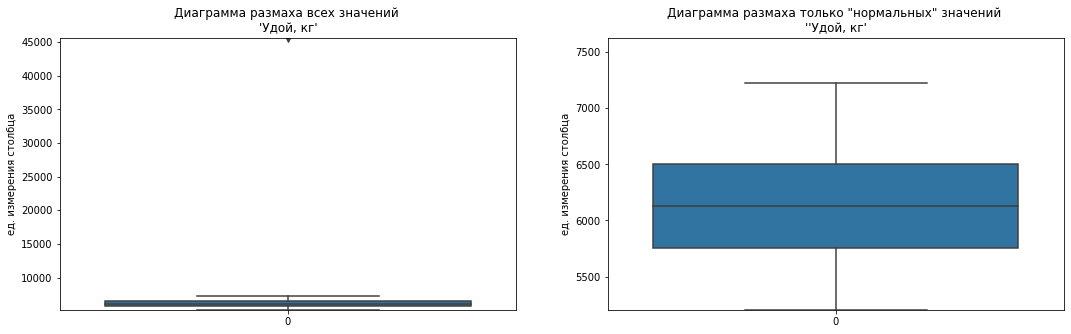

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'Удой, кг':


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы-быка,"Жирность,%","Белок,%",Вкус молока,Возраст
16,17,45616,11.500000,1675,0.930000,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,3.220000,3.076000,вкусно,более_2_лет



Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'Удой, кг':
аномальных значений ниже нижней границы не обнаружено





Статистическое описание данных столбца 'ЭКЕ (Энергетическая кормовая единица)':
count    629.000000
mean      14.543879
std        1.306408
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: ЭКЕ (Энергетическая кормовая единица), dtype: float64

Верхняя граница "нормальных" значений = 18.75
Нижняя граница "нормальных" значений = 10.350000000000001



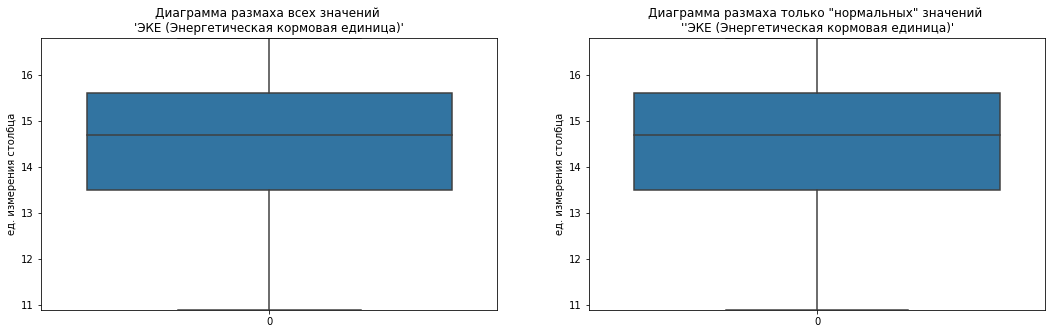

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'ЭКЕ (Энергетическая кормовая единица)':
аномальных значений выше верхней границы не обнаружено

Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'ЭКЕ (Энергетическая кормовая единица)':
аномальных значений ниже нижней границы не обнаружено





Статистическое описание данных столбца 'Сырой протеин, г':
count     629.000000
mean     1923.364070
std       182.956251
min      1660.000000
25%      1771.000000
50%      1888.000000
75%      2062.000000
max      2349.000000
Name: Сырой протеин, г, dtype: float64

Верхняя граница "нормальных" значений = 2498.5
Нижняя граница "нормальных" значений = 1334.5



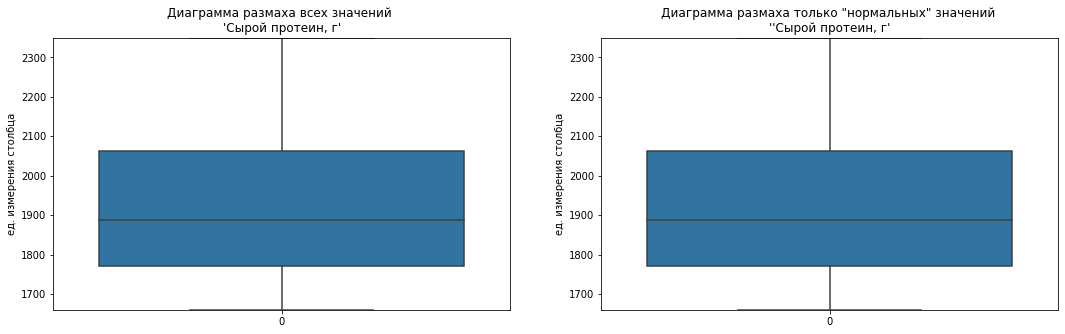

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'Сырой протеин, г':
аномальных значений выше верхней границы не обнаружено

Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'Сырой протеин, г':
аномальных значений ниже нижней границы не обнаружено





Статистическое описание данных столбца 'СПО (Сахаро-протеиновое соотношение)':
count    629.000000
mean       0.913116
std        0.032203
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: СПО (Сахаро-протеиновое соотношение), dtype: float64

Верхняя граница "нормальных" значений = 1.015
Нижняя граница "нормальных" значений = 0.8150000000000002



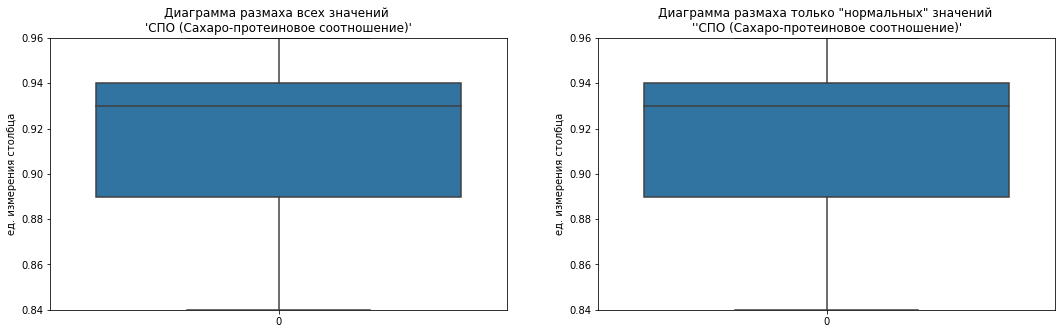

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'СПО (Сахаро-протеиновое соотношение)':
аномальных значений выше верхней границы не обнаружено

Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'СПО (Сахаро-протеиновое соотношение)':
аномальных значений ниже нижней границы не обнаружено





Статистическое описание частоты встречаемости уникальных значений в столбце 'Порода':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
Вис Бик Айдиал      373
Рефлешн Соверинг    256
Name: Порода, dtype: int64



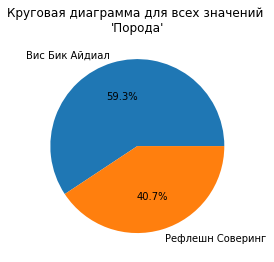





Статистическое описание частоты встречаемости уникальных значений в столбце 'Тип пастбища':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
Холмистое    351
Равнинное    278
Name: Тип пастбища, dtype: int64



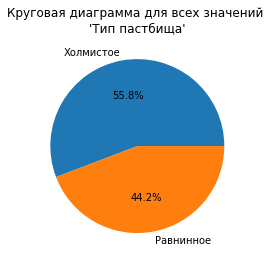





Статистическое описание частоты встречаемости уникальных значений в столбце 'Порода папы-быка':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
Вис Бик Айдиал      318
Рефлешн Соверинг    311
Name: Порода папы-быка, dtype: int64



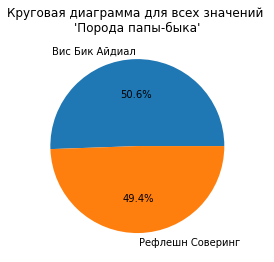





Статистическое описание данных столбца 'Жирность,%':
count    629.000000
mean       3.603657
std        0.168656
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: Жирность,%, dtype: float64

Верхняя граница "нормальных" значений = 3.915000000000001
Нижняя граница "нормальных" значений = 3.3949999999999996



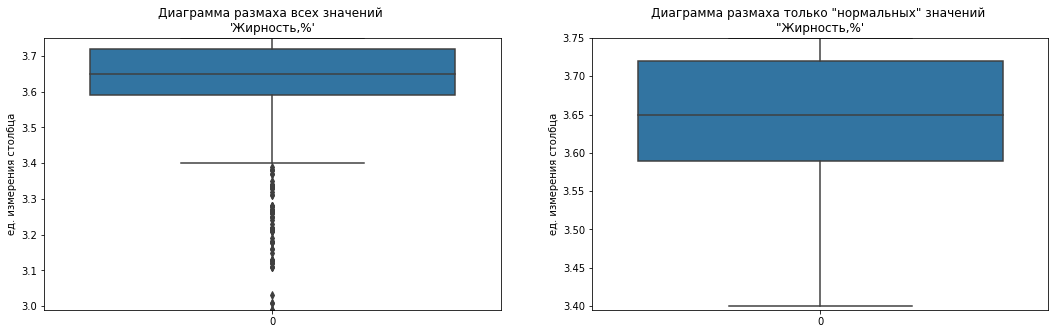

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'Жирность,%':
аномальных значений выше верхней границы не обнаружено

Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'Жирность,%':


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы-быка,"Жирность,%","Белок,%",Вкус молока,Возраст
5,6,5254,12.700000,1806,0.885000,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.130000,3.078000,вкусно,менее_2_лет
9,10,5339,13.400000,1791,0.895000,Вис Бик Айдиал,Холмистое,Рефлешн Соверинг,3.130000,3.075000,вкусно,менее_2_лет
10,11,5591,13.700000,1678,0.895000,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,3.130000,3.075000,вкусно,менее_2_лет
16,17,45616,11.500000,1675,0.930000,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,3.220000,3.076000,вкусно,более_2_лет
17,18,5777,12.400000,1873,0.895000,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,3.030000,3.080000,вкусно,более_2_лет
24,25,5372,13.200000,1703,0.895000,Вис Бик Айдиал,Равнинное,Вис Бик Айдиал,3.310000,3.078000,не вкусно,менее_2_лет
30,31,5242,11.800000,1764,0.885000,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,3.210000,3.078000,вкусно,менее_2_лет
34,35,5356,12.900000,1734,0.885000,Вис Бик Айдиал,Равнинное,Вис Бик Айдиал,3.110000,3.075000,не вкусно,менее_2_лет
36,37,6150,13.800000,1702,0.930000,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,3.110000,3.074000,вкусно,более_2_лет
50,51,5593,13.400000,1675,0.895000,Вис Бик Айдиал,Равнинное,Вис Бик Айдиал,3.250000,3.075000,вкусно,менее_2_лет







Статистическое описание данных столбца 'Белок,%':
count    629.000000
mean       3.075671
std        0.002549
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: Белок,%, dtype: float64

Верхняя граница "нормальных" значений = 3.0815
Нижняя граница "нормальных" значений = 3.0694999999999997



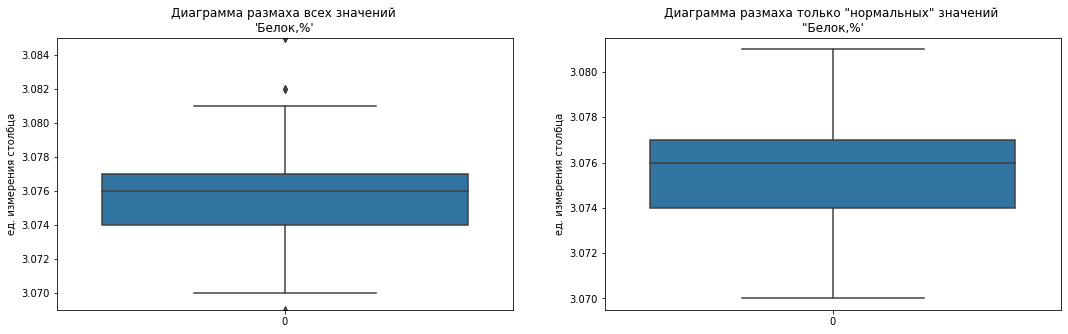

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'Белок,%':


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы-быка,"Жирность,%","Белок,%",Вкус молока,Возраст
77,78,5871,14.700000,1795,0.895000,Вис Бик Айдиал,Равнинное,Вис Бик Айдиал,3.610000,3.082000,вкусно,более_2_лет
426,427,6701,15.700000,2068,0.940000,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,3.720000,3.082000,вкусно,более_2_лет
471,472,5883,14.900000,2159,0.890000,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,3.620000,3.085000,вкусно,более_2_лет
517,518,5819,13.700000,1968,0.840000,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,3.150000,3.085000,вкусно,более_2_лет



Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'Белок,%':


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы-быка,"Жирность,%","Белок,%",Вкус молока,Возраст
240,241,5568,13.400000,1733,0.880000,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,3.630000,3.069000,не вкусно,менее_2_лет







Статистическое описание частоты встречаемости уникальных значений в столбце 'Вкус молока':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
вкусно       371
не вкусно    258
Name: Вкус молока, dtype: int64



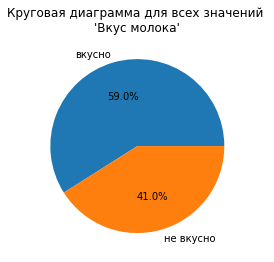





Статистическое описание частоты встречаемости уникальных значений в столбце 'Возраст':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
более_2_лет    519
менее_2_лет    110
Name: Возраст, dtype: int64



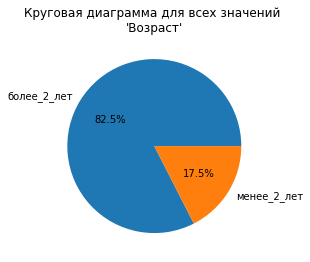

In [43]:
# вызов функции для статистического анализа данных в столбцах, 
# передавая ferma_main с переведенными названиями столбцов с помощью функции
get_full_describe_info_of_data(
    renames_columns_to_rus(ferma_main),
    exception_columns=['id']
)

Обработка аномалий в столбце ***'Удой, кг'*** (*'milk_yield'*) - масса молока, которую корова даёт в год (в килограммах):

Обнаружен выброс - удой с данной коровы зафиксирован как 45616 кг за год (в 9 раз больше, чем медианный удой). Данные выглядят некорректно, при разделении на 1000 (предполагая, что указали удой в граммах) они также выбиваются из общей массы - удалим строку с аномальными данными. 

In [44]:
ferma_main = ferma_main.drop(ferma_main.loc[ferma_main['milk_yield'] > 7625].index)

Обработка аномалий в столбце **'Жирность,%'** (*'fat_content'*) - содержание жиров в молоке (в процентах):

Выбросы обнаружены ниже нижней границы, но выглядят реальными данными (молоко бывает с минимальной жирностью) - оставляем без изменений. 

Обработка аномалий в столбце **'Белок,%'** (*'protein'*) - содержание белков в молоке (в процентах):

Выбросы обнаружены выше верхней границы, но выглядят реальными данными (процент содержания белка минимально отличается от других показателей) - оставляем без изменений. 

### 3.2 Проанализируем данные об именах пап-быков каждой коровы в стаде фермера **ferma_dad**

Статистическое описание частоты встречаемости уникальных значений в столбце 'Имя папы-быка':
количество уникальных значений = 4 шт.
список уникальных значений и их количество:
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: Имя папы-быка, dtype: int64



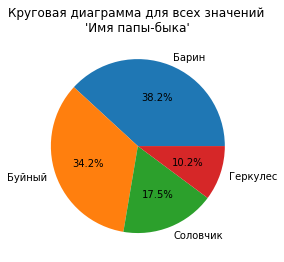

In [45]:
# вызов функции для статистического анализа данных в столбцах
get_full_describe_info_of_data(
    renames_columns_to_rus(ferma_dad),
    exception_columns=['id']
)

### 3.3 Проанализируем данные о коровах на основании **cow_buy**

Статистическое описание частоты встречаемости уникальных значений в столбце 'Порода':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
Рефлешн Соверинг    8
Вис Бик Айдиал      8
Name: Порода, dtype: int64



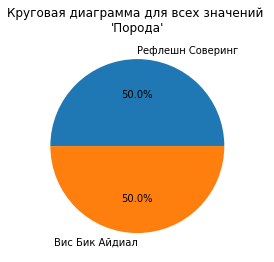





Статистическое описание частоты встречаемости уникальных значений в столбце 'Тип пастбища':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
Равнинное    8
Холмистое    8
Name: Тип пастбища, dtype: int64



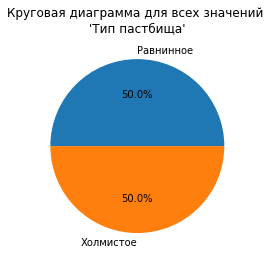





Статистическое описание частоты встречаемости уникальных значений в столбце 'Порода папы-быка':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
Рефлешн Соверинг    10
Вис Бик Айдиал       6
Name: Порода папы-быка, dtype: int64



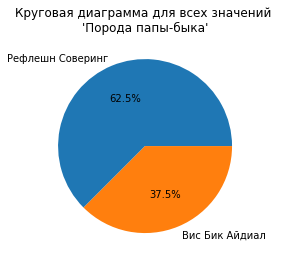





Статистическое описание частоты встречаемости уникальных значений в столбце 'Имя папы-быка':
количество уникальных значений = 4 шт.
список уникальных значений и их количество:
Буйный      7
Геркулес    5
Барин       2
Соловчик    2
Name: Имя папы-быка, dtype: int64



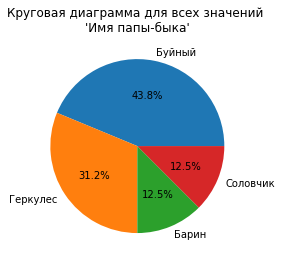





Статистическое описание данных столбца 'Жирность,%':
count    16.000000
mean      3.571875
std       0.141620
min       3.340000
25%       3.415000
50%       3.585000
75%       3.692500
max       3.770000
Name: Жирность,%, dtype: float64

Верхняя граница "нормальных" значений = 4.10875
Нижняя граница "нормальных" значений = 2.9987500000000002



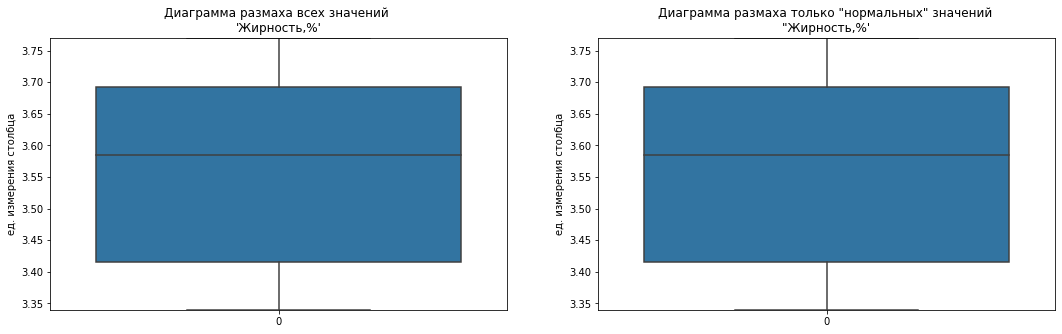

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'Жирность,%':
аномальных значений выше верхней границы не обнаружено

Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'Жирность,%':
аномальных значений ниже нижней границы не обнаружено





Статистическое описание данных столбца 'Белок,%':
count    16.000000
mean      3.068250
std       0.011264
min       3.046000
25%       3.059500
50%       3.073500
75%       3.076750
max       3.081000
Name: Белок,%, dtype: float64

Верхняя граница "нормальных" значений = 3.1026250000000006
Нижняя граница "нормальных" значений = 3.033625



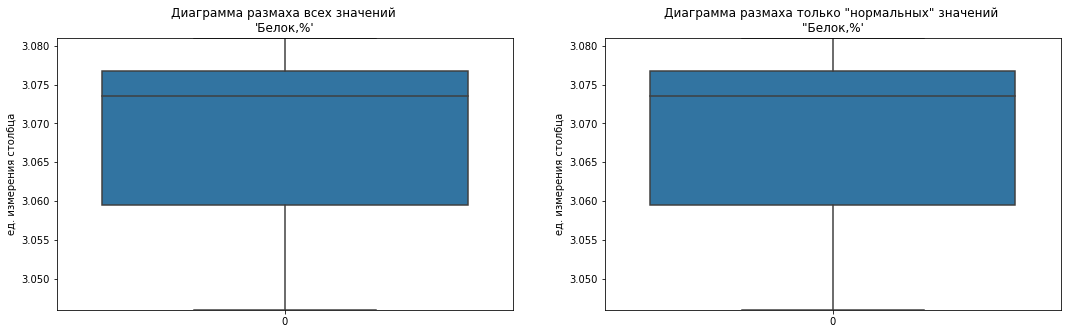

Строки, значения которых выше верхней границы "нормальных" значений столбца 
'Белок,%':
аномальных значений выше верхней границы не обнаружено

Строки, значения которых ниже нижней границы "нормальных" значений столбца 
'Белок,%':
аномальных значений ниже нижней границы не обнаружено





Статистическое описание частоты встречаемости уникальных значений в столбце 'Возраст':
количество уникальных значений = 2 шт.
список уникальных значений и их количество:
более_2_лет    11
менее_2_лет     5
Name: Возраст, dtype: int64



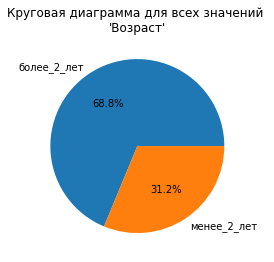

In [46]:
# вызов функции для статистического анализа данных в столбцах
get_full_describe_info_of_data(
    renames_columns_to_rus(cow_buy)
)

Обработка аномалий в столбце **'Белок,%'** (*'protein'*) - содержание белков в молоке (в процентах):

Выбросы обнаружены ниже нижней границы, но выглядят реальными данными (процент содержания белка минимально отличается от других показателей) - оставляем без изменений. 

### 3.4 Описание оценки данных и плана по их улучшению

#### 3.4.1 В рамках статистического анализа текущее стада фермера (ferma_main):

Построим графики распределения значений для оценки их распределения:

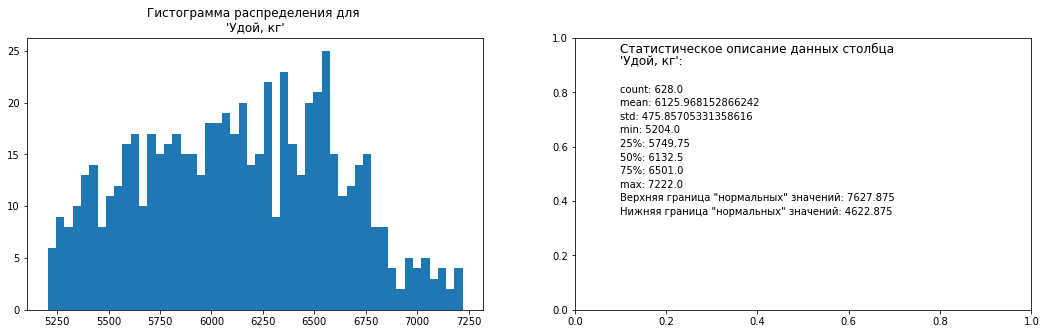

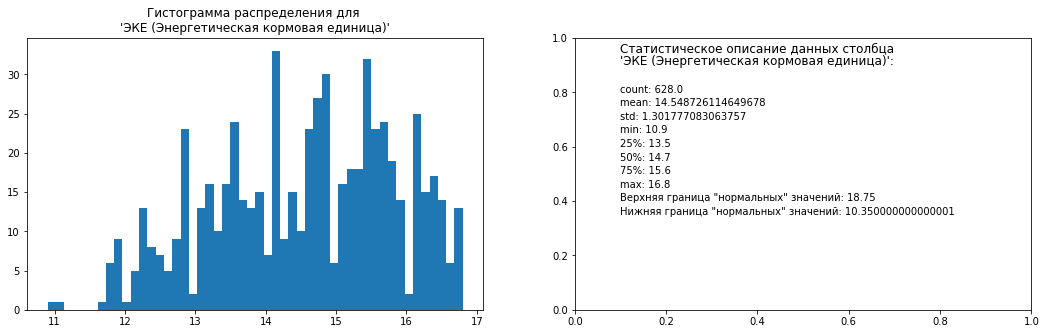

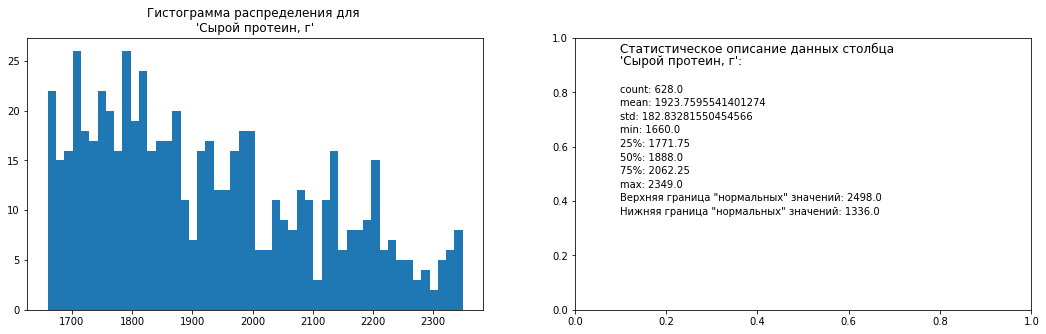

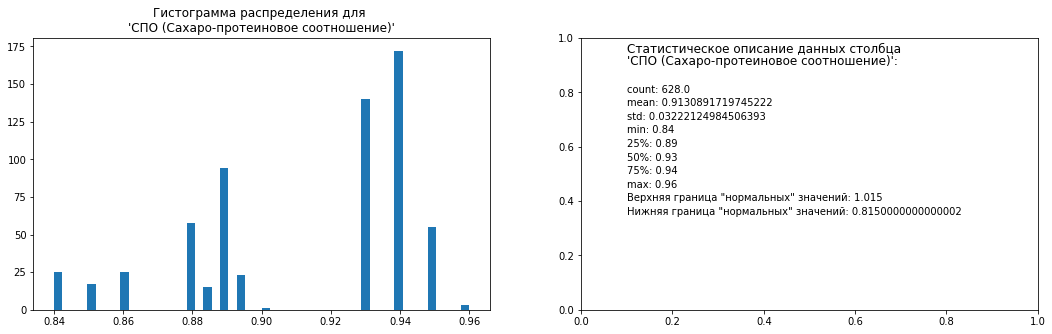

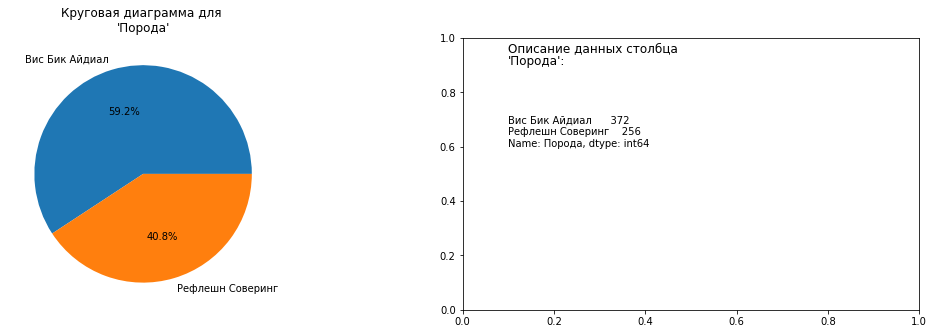

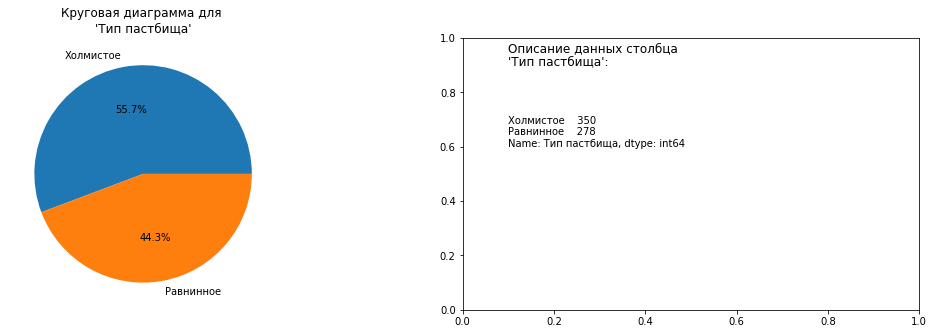

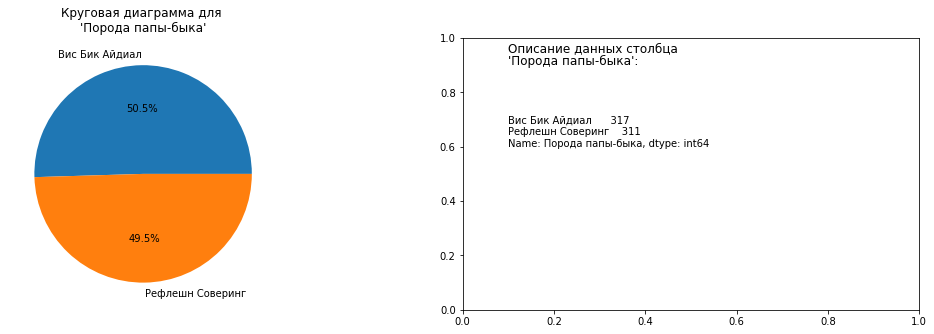

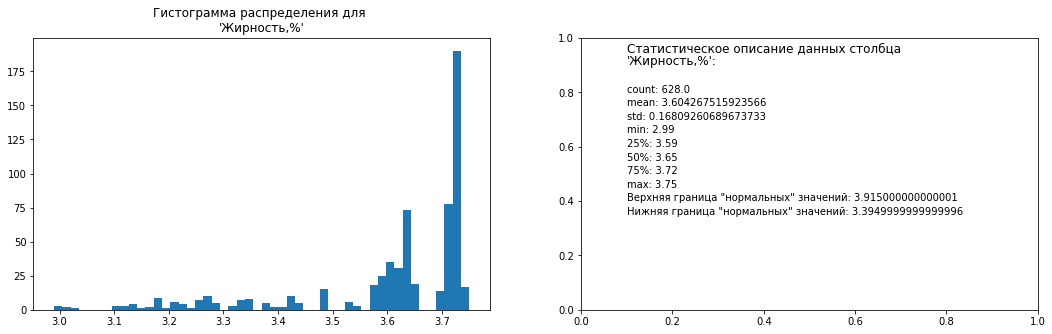

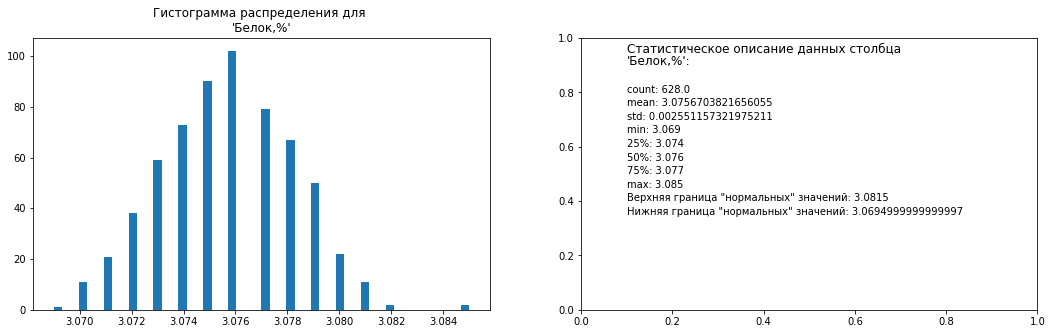

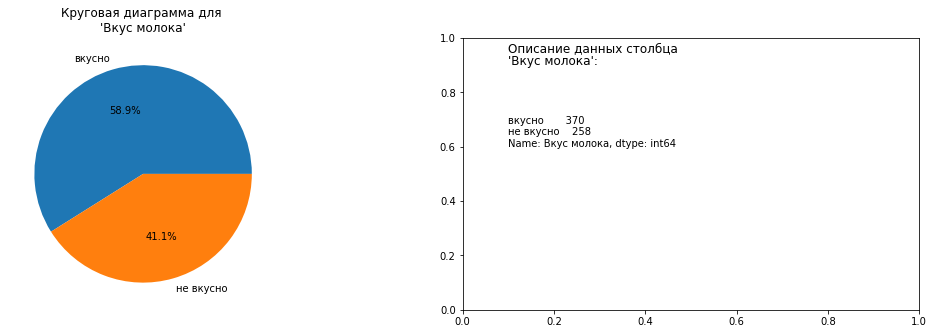

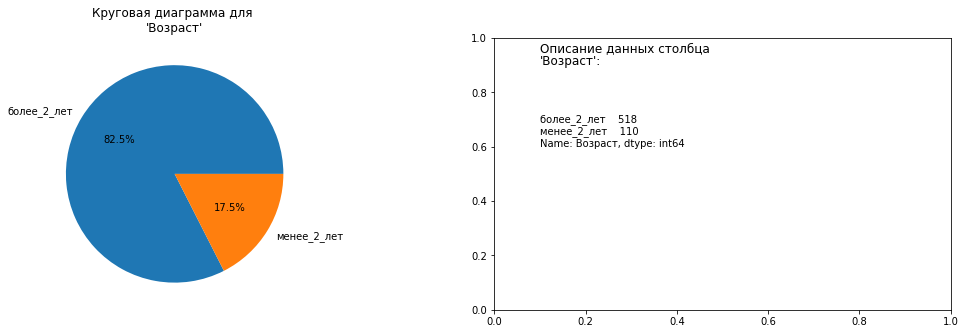

In [47]:
get_distribution_diagrams(
    renames_columns_to_rus(
        ferma_main.drop('id', axis=1)
    )
)

* Столбец ***'Удой, кг'*** (*'milk_yield'*) - масса молока, которую корова даёт в год (в килограммах):
    * Большинство значений лежат в пределах нормы относительно общего объема - от 4623 до 7628; 
    * Медианная масса удоя с одной коровы за год = 6133 кг молока.

* Столбец ***'ЭКЕ (Энергетическая кормовая единица)'*** (*'energy_feed_unit'*) - показатель питательности корма коровы:    
    * Значения лежат в пределах нормы относительно общего объема - от 10 до 18.75; 
    * Медианный показатель питательности корма для одной коровы = 14.7 единиц.

* Столбец ***'Сырой протеин, г'*** (*'crude_protein'*) - содержание сырого протеина в корме (в граммах):    
    * Значения лежат в пределах нормы относительно общего объема - от 1336 до 2498; 
    * Медианный показатель содержания сырого протеина в корме для одной коровы = 1888 грамм.

* Столбец ***'СПО (Сахаро-протеиновое соотношение)'*** (*'sugar_protein_ratio'*) - отношение сахара к протеину в корме коровы:   
    * Значения лежат в пределах нормы относительно общего объема - от 0.815 до 1.015; 
    * Медианный показатель отношения сахара к протеину в корме для одной коровы = 0.93 = 93%.

* Столбец ***'Порода'*** (*'breed'*) - порода коровы:    
    * Всего уникальных значений (пород коров) = 2 породы; 
    * Распределение пород среди коров стада: 
        * Вис Бик Айдиал - 372 коров (59.2%), 
        * Рефлешн Соверинг - 256 коров (40.8%). 

* Столбец ***'Тип пастбища'*** (*'pasture_type'*) - ландшафт лугов, на которых паслась корова:    
    * Всего уникальных значений (типов лугов, на которых пасутся коровы) = 2 типа пастбища; 
    * Распределение типов пастбищ среди коров: 
        * Холмистое - 350 пасущихся коров (55.7%), 
        * Равнинное - 278 пасущихся коров (44.3%).

* Столбец ***'Порода папы-быка'*** (*'breed_of_dad_cow'*) - порода папы коровы:    
    * Всего уникальных значений (пород пап-быков) = 2 породы; 
    * Распределение пород пап-быков: 
        * Вис Бик Айдиал - 317 коров с папой-быком данной породы (50.5%), 
        * Рефлешн Соверинг - 311 коров с папой-быком данной породы (49.5%). 

* Столбец ***'Жирность,%'*** (*'fat_content'*) - содержание жиров в молоке (в процентах):    
    * Большинство значений лежат в пределах нормы относительно общего объема - от 3.395 до 3.915; 
    * Медианный показатель жирности молока одной коровы = 3.65%. 

* Столбец ***'Белок,%'*** (*'protein'*) - содержание белков в молоке (в процентах):    
    * Большинство значений лежат в пределах нормы относительно общего объема - от 3.069 до 3.082; 
    * Медианный показатель содержания белка в молоке одной коровы = 3.076%. 

* Столбец ***'Вкус молока'*** (*'milk_taste'*) - оценка вкуса по личным критериям фермера - вкусно или не вкусно:    
    * Всего уникальных значений (оценок качества вкуса молока) = 2 оценки; 
    * Распределение оценок: 
        * вкусно - 370 коров, дающих молоко данного качества (58.9%), 
        * не вкусно - 258 коров, дающих молоко данного качества (41.1%). 

* Столбец ***'Возраст'*** (*'age'*) - возраст коровы - менее 2 лет или более 2 лет:    
    * Всего уникальных значений (возрастных групп коров) = 2 группы; 
    * Распределение групп: 
        * более 2 лет - 518 взрослых коров (82.5%), 
        * менее 2 лет - 110 молодых коров (17.5%). 

#### 3.4.2 В рамках статистического анализа данных об именах пап-быков у коров в стаде фермера (ferma_dad):

Построим графики распределения значений для оценки их распределения:

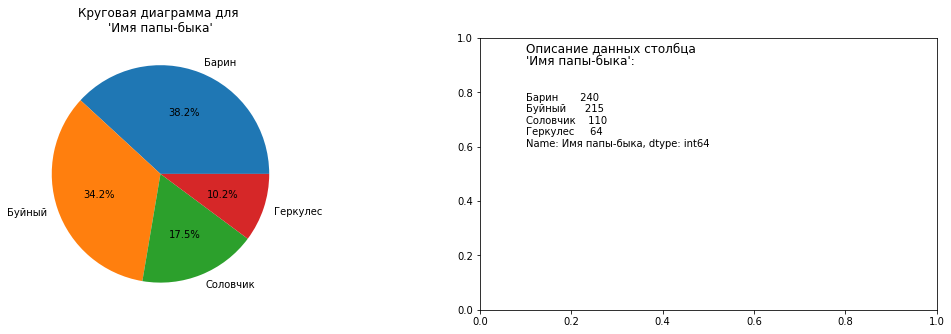

In [48]:
get_distribution_diagrams(
    renames_columns_to_rus(
        ferma_dad.drop('id', axis=1)
    )
)

* Столбец ***'Имя папы-быка'*** (*'name_of_dad_cow'*) - имя папы коровы:    
    * Всего уникальных значений (пап-быков) = 4 папы-быка; 
    * Распределение коров с определенным папой-быком: 
        * Барин - 240 коров с данным папой-быком (38.2%), 
        * Буйный - 215 коров с данным папой-быком (34.2%), 
        * Соловчик - 110 коров с данным папой-быком (17.5%), 
        * Геркулес - 64 коров с данным папой-быком (10.2%). 

#### 3.4.3 В рамках статистического анализа данных о коровах (cow_buy):

Построим графики распределения значений для оценки их распределения:

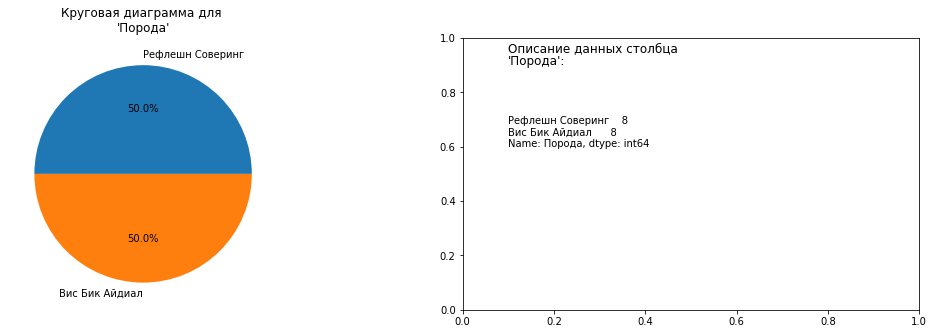

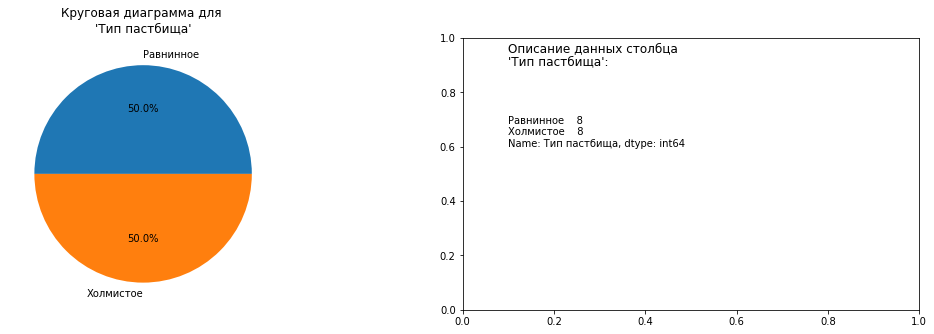

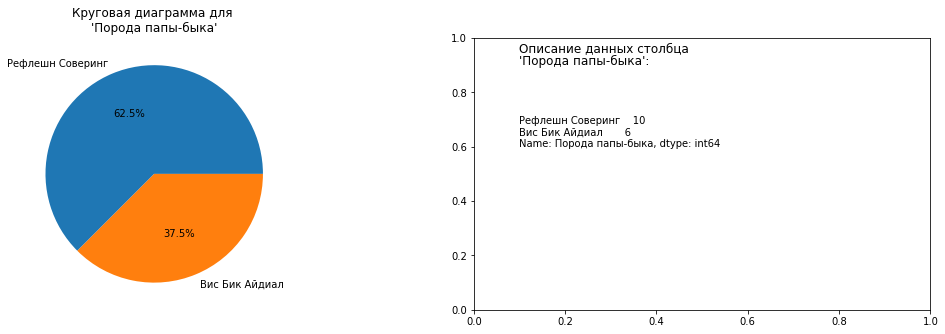

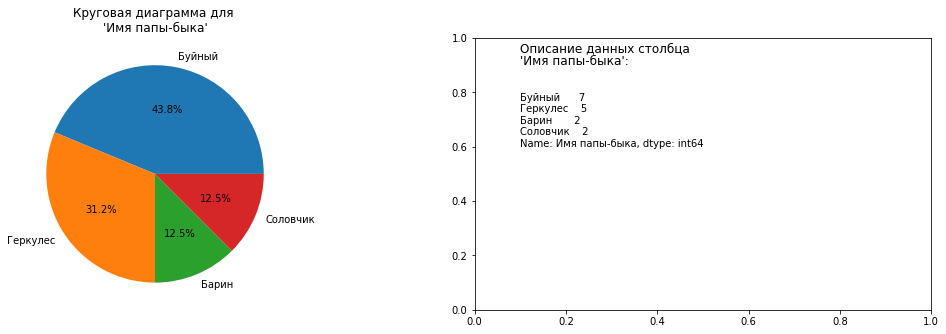

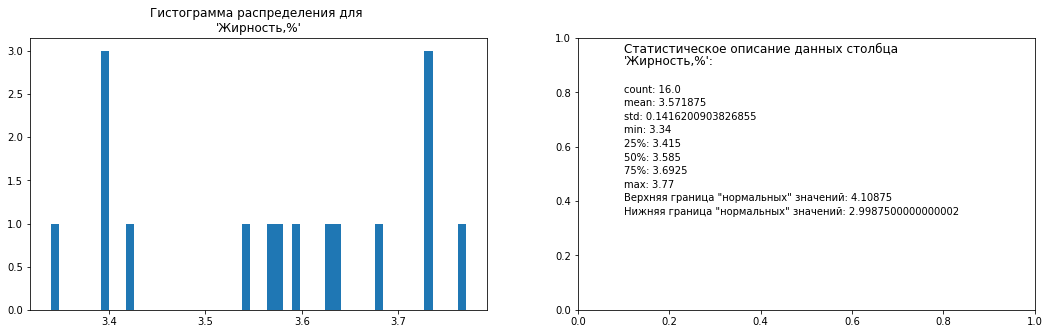

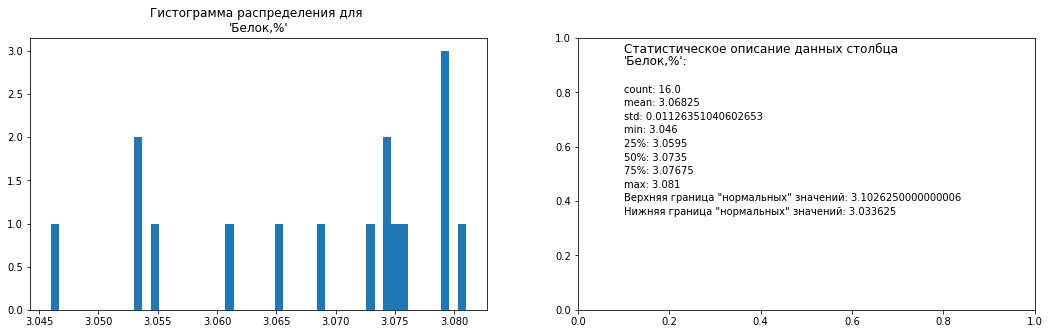

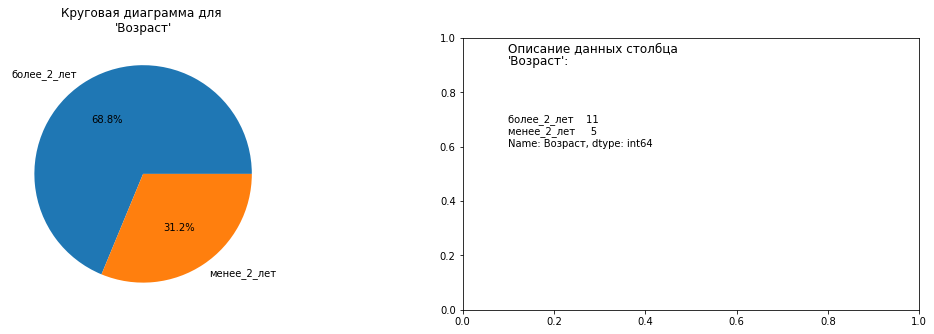

In [49]:
get_distribution_diagrams(
    renames_columns_to_rus(
        cow_buy
    )
)

* Столбец ***'Порода'*** (*'breed'*) - порода коровы:    
    * Всего уникальных значений (пород коров) = 2 породы; 
    * Распределение пород среди коров стада: 
        * Рефлешн Соверинг - 8 коров (50.0%), 
        * Вис Бик Айдиал - 8 коров (50.0%). 

* Столбец ***'Тип пастбища'*** (*'pasture_type'*) - ландшафт лугов, на которых паслась корова:    
    * Всего уникальных значений (типов лугов, на которых пасутся коровы) = 2 типа пастбища; 
    * Распределение типов пастбищ в рамках всей территории: 
        * Равнинное - 8 пасущихся коров (50.0%), 
        * Холмистое - 8 пасущихся коров (50.0%).

* Столбец ***'Порода папы-быка'*** (*'breed_of_dad_cow'*) - порода папы коровы:    
    * Всего уникальных значений (пород пап-быков) = 2 породы; 
    * Распределение пород пап-быков: 
        * Рефлешн Соверинг - 10 коров с папой-быком данной породы (62.5%), 
        * Вис Бик Айдиал - 6 коров с папой-быком данной породы (37.5%). 

* Столбец ***'Имя папы-быка'*** (*'name_of_dad_cow'*) - имя папы коровы:    
    * Всего уникальных значений (пап-быков) = 4 быка; 
    * Распределение коров с определенным папой-быком: 
        * Буйный - 7 коров с данным папой-быком (43.8%), 
        * Геркулес - 5 коров с данным папой-быком (31.2%), 
        * Соловчик - 2 коров с данным папой-быком (12.5%), 
        * Барин - 2 коров с данным папой-быком (12.5%). 

* Столбец ***'Жирность,%'*** (*'fat_content'*) - содержание жиров в молоке (в процентах):    
    * Значения лежат в пределах нормы относительно общего объема - от 3 до 4.11; 
    * Медианный показатель жирности молока одной коровы = 3.59%. 

* Столбец ***'Белок,%'*** (*'protein'*) - содержание белков в молоке (в процентах):    
    * Большинство значений лежат в пределах нормы относительно общего объема - от 3.034 до 3.103; 
    * Медианный показатель содержания белка в молоке одной коровы = 3.074%. 

* Столбец ***'Возраст'*** (*'age'*) - возраст коровы - менее 2 лет или более 2 лет:    
    * Всего уникальных значений (возрастных групп коров) = 2 группы; 
    * Распределение групп: 
        * более 2 лет - 11 взрослых коров (68.8%), 
        * менее 2 лет - 5 молодых коров (31.2%). 

**Выводы:**

Не все данные имеют нормальное распределение.

В ferma_main отсутствует нормальное распределение в следующих столбцах: 
* 'Сырой протеин, г' ('crude_protein'), 
* 'СПО (Сахаро-протеиновое соотношение)' ('sugar_protein_ratio'), 
* 'Жирность,%' ('fat_content').

В cow_buy отсутствует нормальное распределение в следующих столбцах: 
* 'Жирность,%' ('fat_content'), 
* 'Белок,%' ('protein').

## 4. Корреляционный анализ (по данным из ferma_main)

### 4.1 Оценка корреляции между признаками

Построим таблицу корреляции между количественными признаками:

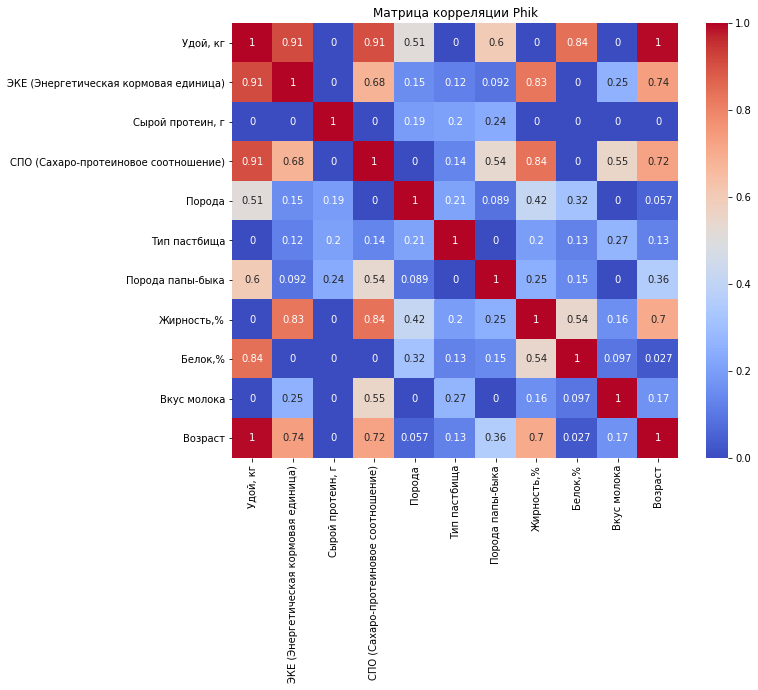

In [50]:
phik_correlation_matrix = renames_columns_to_rus(ferma_main).drop('id', axis=1).phik_matrix(interval_cols=['milk_yield', 'energy_feed_unit', 'crude_protein', 'sugar_protein_ratio', 'fat_content', 'protein'])

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(phik_correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции Phik')
plt.show()

**Весьма высокая (наивысшая) положительная зависимость (свыше 0.9) выявлена между данными:**
* 'milk_yield' ('Удой, кг') и 'energy_feed_unit' ('ЭКЕ (Энергетическая кормовая единица)'):
    
        чем питательнее корм, тем больше корова дает молока, 


* 'milk_yield' ('Удой, кг') и 'sugar_protein_ratio' ('СПО (Сахаро-протеиновое соотношение)'):

        чем выше соотношения сахара к протеину в корме, тем больше корова дает молока, 


* 'milk_yield' ('Удой, кг') и 'age' ('Возраст'):

        если корова взрослая (старше 2 лет), она может давать молоко - до 2 лет корова не телится и не дает молоко. 
    

**Высокая положительная зависимость (0.7-0.9) выявлена между данными:**
* 'milk_yield' ('Удой, кг') и 'protein' ('Белок,%'):

        возможно, данные признаки имеют зависимость от третьего признака, что объясняет их линейную зависимость, т.к. связать объем удоя и содержанием процента белка в молоке напрямую невозможно, 


* 'fat_content' ('Жирность,%') и 'energy_feed_unit' ('ЭКЕ (Энергетическая кормовая единица)'):

        чем выше питательность корма, тем более жирное корова дает молоко,


* 'energy_feed_unit' ('ЭКЕ (Энергетическая кормовая единица)') и 'age' ('Возраст'):

        чем старше корова, тем более питательный корм, которым ее кормят,


* 'fat_content' ('Жирность,%') и 'sugar_protein_ratio' ('СПО (Сахаро-протеиновое соотношение)'):

        чем выше отношение сахара к протеину в корме коровы, тем более жирное корова дает молоко,
    

* 'sugar_protein_ratio' ('СПО (Сахаро-протеиновое соотношение)') и 'age' ('Возраст'):

        чем старше корова, тем выше отношение сахара к протеину в корме, которым ее кормят,


* 'fat_content' ('Жирность,%') и 'age' ('Возраст'):

        чем старше корова, тем больше процент жирности в ее молоке.

### 4.2 Построение диаграмм рассеивания для  массы молока, которую корова даёт в год, и других признаков

Построим диаграммы рассеивания для столбца ***'milk_yield'*** (*'Удой, кг'*) и других столбцов с количественными данными:

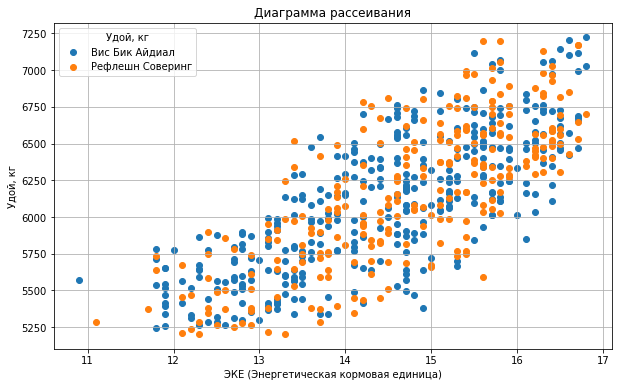

Степень корреляции - высокая(+) (0.7650977877344268)






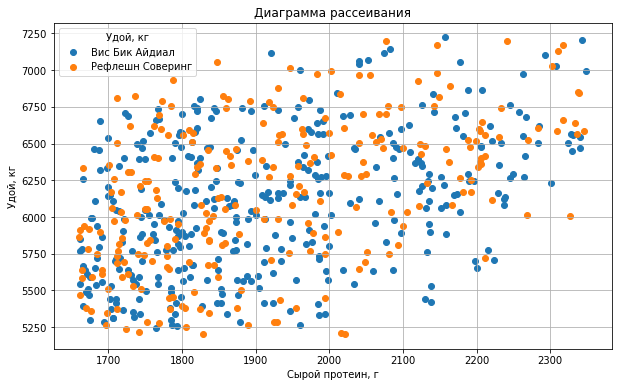

Степень корреляции - умеренная(+) (0.4467312546088666)






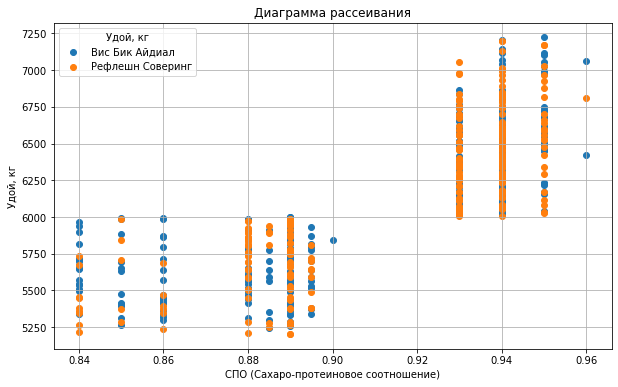

Степень корреляции - высокая(+) (0.8063389252912262)






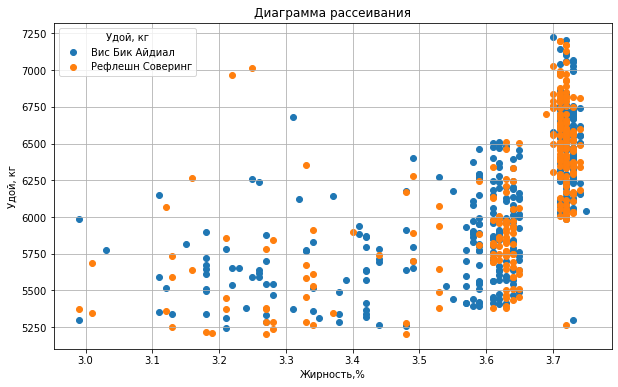

Степень корреляции - заметная(+) (0.6009018484316156)






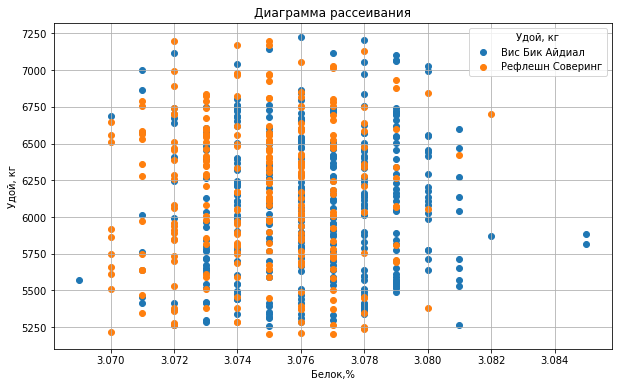

Степень корреляции - низкая(+) (0.002965710114691232)






In [51]:
building_scattering_diagrams(renames_columns_to_rus(ferma_main).drop('id', axis=1), 'Удой, кг', 'Порода')

### 4.3 Выводы о взаимосвязи признаков

**Выводы:**

Наибольшее влияние на удой оказывают: 
   * энергетическая кормовая единица корма, 
   * сахаро-протеиновое соотношение в корме, 
   * возраст. 
   
Мультиколлинеарности между будущими входными признаками при прогнозировании объема удоя не наблюдается. 

При прогнозировании вкуса молока необходимо будет исключить 'milk_yield' ('Удой, кг') для исключения неустойчивости модели.

## 5. Задача регрессии - прогноз объема молока

### 5.1 Обучение первой модели

Подготовим данные **ferma_main** и обучим на них первую модель LinearRegression.

Используем в качестве целевого признак 'milk_yield' ('Удой, кг'). Оптимальные входящие признаки нам вернет функция "get_combinations_for_ln_reg_model".

Оптимальные входящие признаки для прогнозирования первой модели:

* 'energy_feed_unit' ('ЭКЕ (Энергетическая кормовая единица)') - наблюдается высокая положительная линейная зависимость, обоснованная логически: чем питательнее корм, тем больше корова дает молока; 
* 'crude_protein' ('Сырой протеин, г') - наблюдается умеренная линейная зависимость, обоснованная логически: чем больше содержание сырого протеина в корме, тем больше корова дает молока; 
* 'sugar_protein_ratio' ('СПО (Сахаро-протеиновое соотношение)') - наблюдается высокая положительная линейная зависимость, обоснованная логически: чем выше содержание сахара по отношению к протеину в корме, тем более питательный корм; 
* 'breed' ('Порода') - удой может зависеть от породы самой коровы; 
* 'pasture_type' ('Тип пастбища') - от местности, гд пасется корова, может зависеть ее рацион и, как следствие, удой; 
* 'breed_of_dad_cow' ('Порода папы-быка') - удой может зависеть не только от породы коровы, но и как следствие от породы ее папы-быка, 
* 'age' ('Возраст') - удой модет зависеть от возраста коровы. 

In [52]:
# Столбцы с количественным признаком
all_num_col_names = ['energy_feed_unit', 'crude_protein', 'sugar_protein_ratio']
# Столбцы с категориальным признаком
all_cat_col_names = ['breed', 'pasture_type', 'breed_of_dad_cow', 'age']

# Получение DataFrame с результатами обучения на разных комбинациях столбцов с входящими признаками
df_1_for_ln_reg_results_of_def = learning_ln_reg_model(
    ferma_main[['energy_feed_unit', 'crude_protein', 'sugar_protein_ratio', 'breed', 'pasture_type', 'breed_of_dad_cow', 'age']], 
    ferma_main['milk_yield'], 
    all_num_col_names, 
    all_cat_col_names)

# Вывод полученного DataFrame с результатами
df_1_for_ln_reg_results_of_def

R^2 = 0.7844078173416967


MSE = 43887.015009660514


RMSE = 209.4922791170608


MAE = 164.24194463474925




/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,combination,r^2,mse,rmse,mae,X_test,predictions,y_test,model_as_ln_regression,scaler,encoder
0,"[energy_feed_unit, crude_protein, sugar_protei...",0.784408,43887.01501,209.492279,164.241945,energy_feed_unit crude_protein sugar_pr...,"[6031.538080695898, 6433.102409373978, 5459.59...",582 5980 592 6512 551 5392 214 560...,LinearRegression(),StandardScaler(),"OneHotEncoder(drop='first', handle_unknown='ig..."


Оценим качество модели:

Коэффициент детерминации = 0.78 = 78.0%
Средний квадрат ошибок = 43887.02
Корень из среднего квадрата ошибок = 209.49
Средняя абсолютная ошибка = 164.24


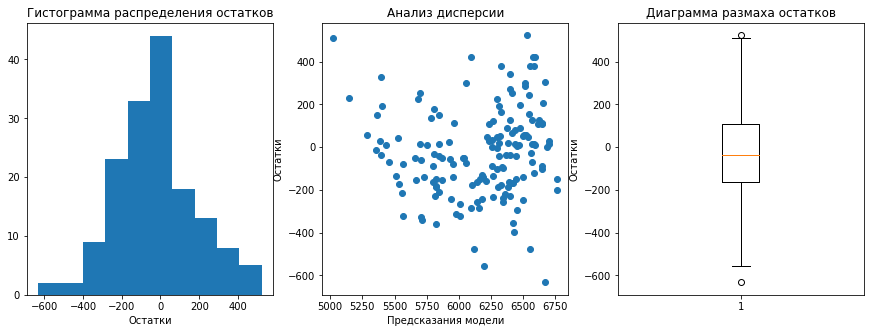

In [53]:
# Коэффициент детерминации
r2 = df_1_for_ln_reg_results_of_def.iloc[0]['r^2']
# Коэффициент детерминации
r2 = df_1_for_ln_reg_results_of_def.iloc[0]['r^2']
# Средний квадрат ошибок
mse = df_1_for_ln_reg_results_of_def.iloc[0]['mse']
# Корень из среднего квадрата ошибок
rmse = df_1_for_ln_reg_results_of_def.iloc[0]['rmse']
# Средняя абсолютная ошибка
mae = df_1_for_ln_reg_results_of_def.iloc[0]['mae']

print(f'Коэффициент детерминации = {round(r2, 2)} = {round(r2 * 100, 0)}%')
print(f'Средний квадрат ошибок = {round(mse, 2)}')
print(f'Корень из среднего квадрата ошибок = {round(rmse, 2)}')
print(f'Средняя абсолютная ошибка = {round(mae, 2)}')

# Спрогнозированные значения
predictions = df_1_for_ln_reg_results_of_def.iloc[0]['predictions']

# Анализ остатков
residuals = df_1_for_ln_reg_results_of_def.iloc[0]['y_test'] - predictions

# Строим гистограмму распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

axes[2].boxplot(residuals)
axes[2].set_ylabel('Остатки')
axes[2].set_title('Диаграмма размаха остатков')

plt.show()

**Выводы о первой модели:** 

1. Коэффициент детерминации равен 0.78 и стремится к 1 - качество модели неплохое, но нужно лучше; 
2. Гистограмма остатков показывает симметричное нормальное распределение - модель дает как завышенные, так и заниженные предсказания, которые компенсируют друг друга, поэтому делаем вывод о качественной работе модели; 
3. Диаграмма рассеивания остатков показывает разную дисперсию на разных участках - модель нуждается в доработке. 

Итог - модель необходимо улучшить для повышения качества. 

### 5.2 Обучение второй модели

Для улучшения качества модели исключим нелинейность между целевым признаком и входными: 
* 'sugar_protein_ratio' ('СПО (Сахаро-протеиновое соотношение)'), 
* 'energy_feed_unit' ('ЭКЕ (Энергетическая кормовая единица)'). 

***СПО (Сахаро-протеиновое соотношение):***

Продублируем диаграмму рассеивания:

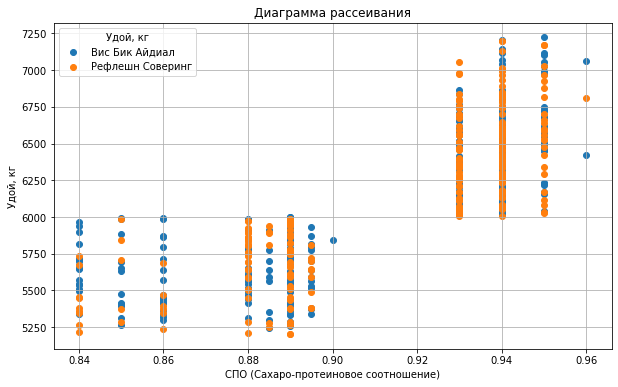

Степень корреляции - высокая(+) (0.8063389252912262)






In [54]:
building_scattering_diagrams(renames_columns_to_rus(ferma_main[['milk_yield', 'sugar_protein_ratio', 'breed']]), 'Удой, кг', 'Порода')

Добавим новый столбец, где укажем бинарный признак - "СПО выше 91%":

In [55]:
ferma_main['sugar_protein_ratio_upper_91_procent'] = ferma_main['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.91 else 0)

Построим диаграмму рассеивания для нового признака:

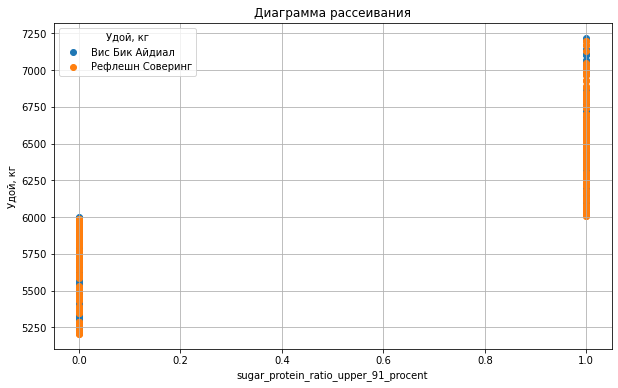

Степень корреляции - высокая(+) (0.8342431244356762)






In [56]:
building_scattering_diagrams(renames_columns_to_rus(ferma_main[['milk_yield', 'sugar_protein_ratio_upper_91_procent', 'breed']]), 'Удой, кг', 'Порода')

***ЭКЕ (Энергетическая кормовая единица):***

Продублируем диаграмму рассеивания:

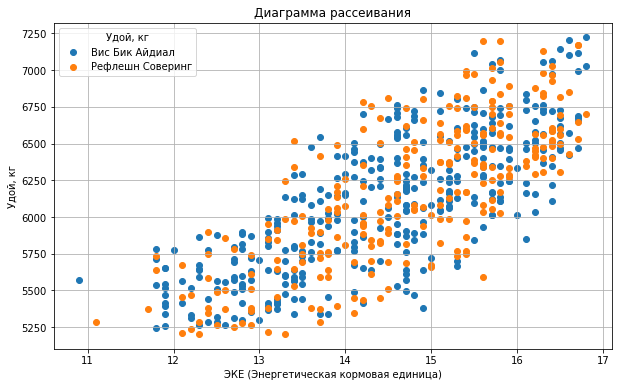

Степень корреляции - высокая(+) (0.7650977877344268)






In [57]:
building_scattering_diagrams(renames_columns_to_rus(ferma_main[['milk_yield', 'energy_feed_unit', 'breed']]), 'Удой, кг', 'Порода')

Добавим новый столбец, где укажем значения в квадрате - "ЭКЕ^2":

In [58]:
ferma_main['energy_feed_unit_to_square'] = ferma_main['sugar_protein_ratio'].apply(lambda x: x ** 2)

Построим диаграмму рассеивания для нового признака:

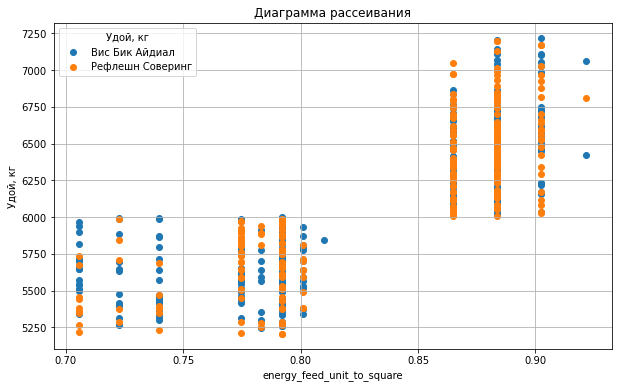

Степень корреляции - высокая(+) (0.8093780256807289)






In [59]:
building_scattering_diagrams(renames_columns_to_rus(ferma_main[['milk_yield', 'energy_feed_unit_to_square', 'breed']]), 'Удой, кг', 'Порода')

***Обучим вторую модель:***

Отберем входящие признаки для прогнозирования (используем входные признаки из первой модели, но заменим 'sugar_protein_ratio' и 'energy_feed_unit' на преобразованные признаки):

* 'energy_feed_unit_to_square' ('ЭКЕ (Энергетическая кормовая единица) в квадрате') - наблюдается высокая положительная линейная зависимость, обоснованная логически: чем питательнее корм, тем больше корова дает молока; 
* 'crude_protein' ('Сырой протеин, г') - наблюдается умеренная линейная зависимость, обоснованная логически: чем больше содержание сырого протеина в корме, тем больше корова дает молока; 
* 'sugar_protein_ratio_upper_91_procent' ('СПО (Сахаро-протеиновое соотношение) выше 91%') - наблюдается высокая положительная линейная зависимость, обоснованная логически: чем выше содержание сахара по отношению к протеину в корме, тем более питательный корм; 
* 'breed' ('Порода') - удой может зависеть от породы самой коровы; 
* 'pasture_type' ('Тип пастбища') - от местности, гд пасется корова, может зависеть ее рацион и, как следствие, удой; 
* 'breed_of_dad_cow' ('Порода папы-быка') - удой может зависеть не только от породы коровы, но и как следствие от породы ее папы-быка, 
* 'age' ('Возраст') - удой модет зависеть от возраста коровы. 

In [60]:
# Столбцы с количественным признаком
all_num_col_names = ['energy_feed_unit_to_square', 'crude_protein', 'sugar_protein_ratio_upper_91_procent']
# Столбцы с категориальным признаком
all_cat_col_names = ['breed', 'pasture_type', 'breed_of_dad_cow', 'age']

# Получение DataFrame с результатами обучения на разных комбинациях столбцов с входящими признаками
df_2_for_ln_reg_results_of_def = learning_ln_reg_model(
    ferma_main[['energy_feed_unit_to_square', 'crude_protein', 'sugar_protein_ratio_upper_91_procent', 'breed', 'pasture_type', 'breed_of_dad_cow', 'age']], 
    ferma_main['milk_yield'], 
    all_num_col_names, 
    all_cat_col_names)

# Вывод полученного DataFrame с результатами
df_2_for_ln_reg_results_of_def

R^2 = 0.7861513234962907


MSE = 43532.09824119226


RMSE = 208.6434715997418


MAE = 167.38302319371607




/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,combination,r^2,mse,rmse,mae,X_test,predictions,y_test,model_as_ln_regression,scaler,encoder
0,"[energy_feed_unit_to_square, crude_protein, su...",0.786151,43532.098241,208.643472,167.383023,energy_feed_unit_to_square crude_protein...,"[5920.745409772562, 6364.7560863435465, 5393.9...",582 5980 592 6512 551 5392 214 560...,LinearRegression(),StandardScaler(),"OneHotEncoder(drop='first', handle_unknown='ig..."


Оценим качество модели:

Коэффициент детерминации = 0.79 = 79.0%
Средний квадрат ошибок = 43532.1
Корень из среднего квадрата ошибок = 208.64
Средняя абсолютная ошибка = 167.38


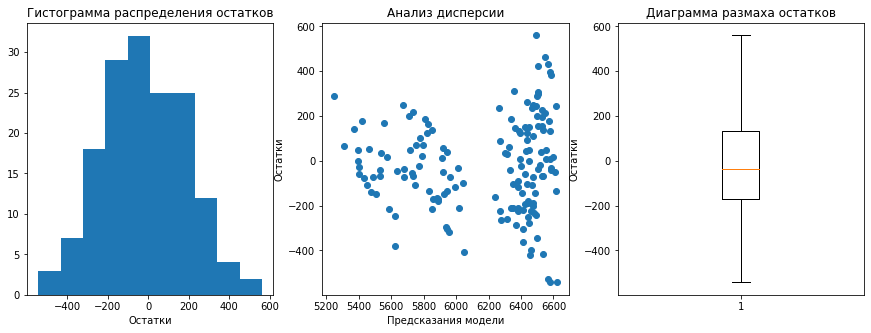

In [61]:
# Коэффициент детерминации
r2 = df_2_for_ln_reg_results_of_def.iloc[0]['r^2']
# Средний квадрат ошибок
mse = df_2_for_ln_reg_results_of_def.iloc[0]['mse']
# Корень из среднего квадрата ошибок
rmse = df_2_for_ln_reg_results_of_def.iloc[0]['rmse']
# Средняя абсолютная ошибка
mae = df_2_for_ln_reg_results_of_def.iloc[0]['mae']

print(f'Коэффициент детерминации = {round(r2, 2)} = {round(r2 * 100, 0)}%')
print(f'Средний квадрат ошибок = {round(mse, 2)}')
print(f'Корень из среднего квадрата ошибок = {round(rmse, 2)}')
print(f'Средняя абсолютная ошибка = {round(mae, 2)}')

# Спрогнозированные значения
predictions = df_2_for_ln_reg_results_of_def.iloc[0]['predictions']

# Анализ остатков
residuals = df_2_for_ln_reg_results_of_def.iloc[0]['y_test'] - predictions

# Строим гистограмму распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

axes[2].boxplot(residuals)
axes[2].set_ylabel('Остатки')
axes[2].set_title('Диаграмма размаха остатков')

plt.show()

**Выводы о второй модели:** 

1. Коэффициент детерминации равен 0.79 и стремится к 1 - качество модели неплохое, но нужно лучше; 
2. Гистограмма остатков показывает нормальное распределение с небольшим смещением влево - некритично, но модель чаще недооценивает объем удоя для коров, чем переоценивает; 
3. Диаграмма рассеивания остатков показывает разную дисперсию на разных участках - модель нуждается в доработке. 

Итог - модель необходимо улучшить для повышения качества. 

### 5.3 Обучение третьей модели

Для улучшения качества модели добавим в **ferma_main** признак 'name_of_dad_cow' ('Имя папы-быка') из **ferma_dad**.

In [62]:
ferma_main = pd.merge(ferma_main, ferma_dad, on='id')

ferma_main.head()

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad_cow,fat_content,protein,milk_taste,age,sugar_protein_ratio_upper_91_procent,energy_feed_unit_to_square,name_of_dad_cow
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,0,0.792100,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,3.54,3.079,вкусно,менее_2_лет,0,0.792100,Соловчик
2,3,5810,14.0,1854,0.885,Рефлешн Соверинг,Холмистое,Рефлешн Соверинг,3.59,3.074,не вкусно,более_2_лет,0,0.783225,Барин
3,4,5895,12.4,2012,0.885,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,0,0.783225,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,3.73,3.073,вкусно,менее_2_лет,0,0.783225,Барин


Проверим наличие пропусков после добавления столбца:

In [63]:
if (ferma_main['name_of_dad_cow'].isna().sum() > 0):
    print('В столбце \'name_of_dad_cow\' имеются пропуски - ', end='')
    print(ferma_main['name_of_dad_cow'].isna().sum())
else:
    print('В столбце \'name_of_dad_cow\' пропусков не обнаружено')

В столбце 'name_of_dad_cow' пропусков не обнаружено


***Обучим третью модель:***

Отберем входящие признаки для прогнозирования (используем входящие признаки из второй модели, но вместо 'breed_of_dad_cow' используем 'name_of_dad_cow':

* 'energy_feed_unit_to_square' ('ЭКЕ (Энергетическая кормовая единица) в квадрате') - наблюдается высокая положительная линейная зависимость, обоснованная логически: чем питательнее корм, тем больше корова дает молока; 
* 'crude_protein' ('Сырой протеин, г') - наблюдается умеренная линейная зависимость, обоснованная логически: чем больше содержание сырого протеина в корме, тем больше корова дает молока; 
* 'sugar_protein_ratio_upper_91_procent' ('СПО (Сахаро-протеиновое соотношение) выше 91%') - наблюдается высокая положительная линейная зависимость, обоснованная логически: чем выше содержание сахара по отношению к протеину в корме, тем более питательный корм; 
* 'breed' ('Порода') - удой может зависеть от породы самой коровы; 
* 'pasture_type' ('Тип пастбища') - от местности, гд пасется корова, может зависеть ее рацион и, как следствие, удой; 
* 'name_of_dad_cow' ('Имя папы-быка') - удой может зависеть не только от породы коровы, но и как следствие от характеристик ее папы-быка, для этого учтем зависимость от конкретного быка-производителя; 
* 'age' ('Возраст') - удой модет зависеть от возраста коровы. 

In [64]:
# Столбцы с количественным признаком
all_num_col_names = ['energy_feed_unit_to_square', 'crude_protein', 'sugar_protein_ratio_upper_91_procent']
# Столбцы с категориальным признаком
all_cat_col_names = ['breed', 'pasture_type', 'name_of_dad_cow', 'age']

# Получение DataFrame с результатами обучения на разных комбинациях столбцов с входящими признаками
df_3_for_ln_reg_results_of_def = learning_ln_reg_model(
    ferma_main[['energy_feed_unit_to_square', 'crude_protein', 'sugar_protein_ratio_upper_91_procent', 'breed', 'pasture_type', 'name_of_dad_cow', 'age']], 
    ferma_main['milk_yield'], 
    all_num_col_names, 
    all_cat_col_names)

# Вывод полученного DataFrame с результатами
df_3_for_ln_reg_results_of_def

R^2 = 0.8039573870605893


MSE = 39907.407543812544


RMSE = 199.76838474546602


MAE = 162.8932358003588




/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,combination,r^2,mse,rmse,mae,X_test,predictions,y_test,model_as_ln_regression,scaler,encoder
0,"[energy_feed_unit_to_square, crude_protein, su...",0.803957,39907.407544,199.768385,162.893236,energy_feed_unit_to_square crude_protein...,"[6010.505055601237, 6382.443112779792, 5409.74...",581 5980 591 6512 550 5392 213 560...,LinearRegression(),StandardScaler(),"OneHotEncoder(drop='first', handle_unknown='ig..."


Оценим качество модели:

Коэффициент детерминации = 0.8 = 80.0%
Средний квадрат ошибок = 39907.41
Корень из среднего квадрата ошибок = 199.77
Средняя абсолютная ошибка = 162.89


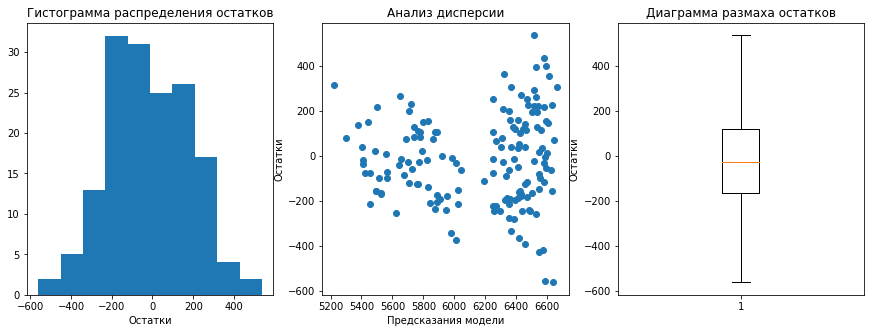

In [65]:
# Коэффициент детерминации
r2 = df_3_for_ln_reg_results_of_def.iloc[0]['r^2']
# Средний квадрат ошибок
mse = df_3_for_ln_reg_results_of_def.iloc[0]['mse']
# Корень из среднего квадрата ошибок
rmse = df_3_for_ln_reg_results_of_def.iloc[0]['rmse']
# Средняя абсолютная ошибка
mae = df_3_for_ln_reg_results_of_def.iloc[0]['mae']

print(f'Коэффициент детерминации = {round(r2, 2)} = {round(r2 * 100, 0)}%')
print(f'Средний квадрат ошибок = {round(mse, 2)}')
print(f'Корень из среднего квадрата ошибок = {round(rmse, 2)}')
print(f'Средняя абсолютная ошибка = {round(mae, 2)}')

# Спрогнозированные значения
predictions = df_3_for_ln_reg_results_of_def.iloc[0]['predictions']

# Анализ остатков
residuals = df_3_for_ln_reg_results_of_def.iloc[0]['y_test'] - predictions

# Строим гистограмму распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

axes[2].boxplot(residuals)
axes[2].set_ylabel('Остатки')
axes[2].set_title('Диаграмма размаха остатков')

plt.show()

**Выводы о третьей модели:** 

1. Модель корректно предсказывает в 76% случаев, 
2. Гистограмма остатков показывает мультимодальное распределение - модель работает недостаточно точно, 
3. Диаграмма рассеивания остатков показывает разную дисперсию на разных участках - модель непредсказуема, прогнозы могут быть ненадежными, 
3. модель необходимо улучшить для повышения качества. 


1. Коэффициент детерминации равен 0.80 и стремится к 1 - качество модели неплохое; 
2. Гистограмма остатков показывает смещенное нормальное распределение влево - модель чаще недооценивает объем удоя для коров, чем переоценивает; 
3. Диаграмма рассеивания остатков показывает разную дисперсию на разных участках - модель нуждается в доработке. 

Итог - модель необходимо улучшить для повышения качества. 

### 5.4 Сравнение качества моделей по показателям (R^2, MSE, RMSE, MAE)

Создадим DataFrame с показателями каждой модели и выведем на экран.

Также выведем графики по показателям остатков.

,parameter,model_1,model_2,model_3
0,R^2,0.78,0.79,0.80
1,MSE,43887.02,43532.10,39907.41
2,RMSE,209.49,208.64,199.77
3,MAE,164.24,167.38,162.89


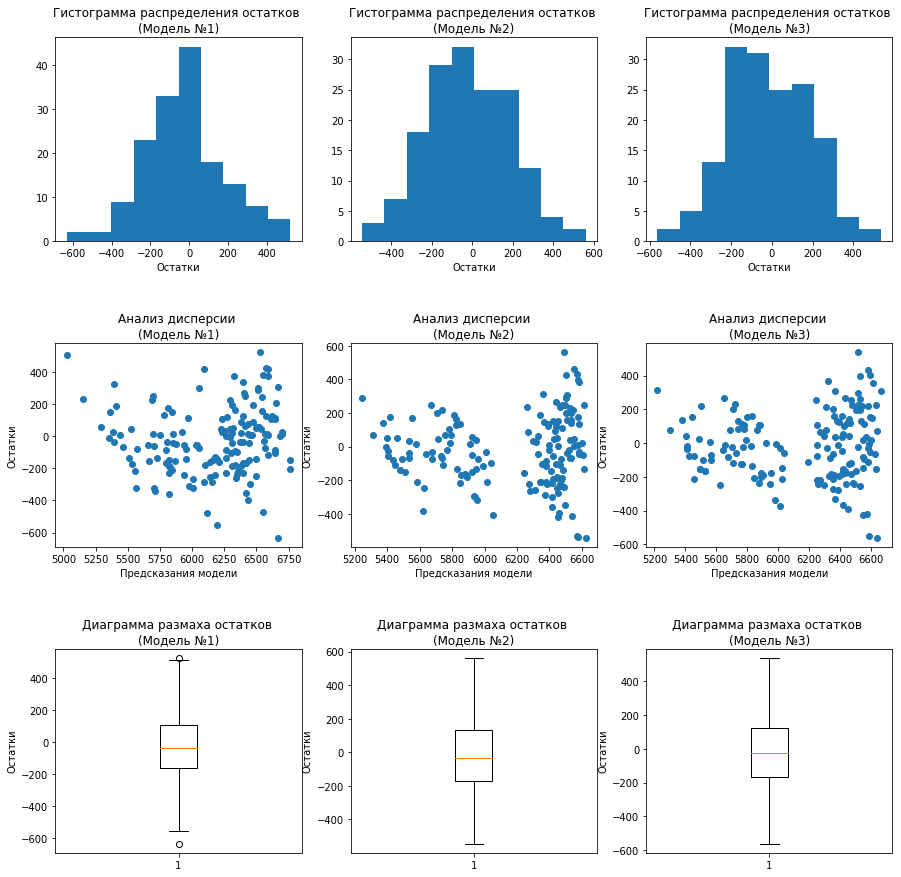

Доверительные интервалы для моделей:
Модель №1: [-402.9079308679499, 420.1994183602995]
Модель №2: [-415.4935281597923, 401.06339569466695]
Модель №3: [-394.7123258164722, 369.5914038733531]


In [66]:
general_df_for_ln_reg_results = pd.DataFrame(columns=['parameter', 'model_1', 'model_2', 'model_3'])

# Вносим коэффициенты детерминации
general_df_for_ln_reg_results.loc[len(general_df_for_ln_reg_results)] = [
    'R^2',
    round(df_1_for_ln_reg_results_of_def.iloc[0]['r^2'], 2),
    round(df_2_for_ln_reg_results_of_def.iloc[0]['r^2'], 2),
    round(df_3_for_ln_reg_results_of_def.iloc[0]['r^2'], 2)
]

# Вносим средние квадраты ошибок
general_df_for_ln_reg_results.loc[len(general_df_for_ln_reg_results)] = [
    'MSE',
    round(df_1_for_ln_reg_results_of_def.iloc[0]['mse'], 2),
    round(df_2_for_ln_reg_results_of_def.iloc[0]['mse'], 2),
    round(df_3_for_ln_reg_results_of_def.iloc[0]['mse'], 2)
]

# Вносим корни из средних квадратов ошибок
general_df_for_ln_reg_results.loc[len(general_df_for_ln_reg_results)] = [
    'RMSE',
    round(df_1_for_ln_reg_results_of_def.iloc[0]['rmse'], 2),
    round(df_2_for_ln_reg_results_of_def.iloc[0]['rmse'], 2),
    round(df_3_for_ln_reg_results_of_def.iloc[0]['rmse'], 2)
]

# Вносим средние абсолютные ошибки
general_df_for_ln_reg_results.loc[len(general_df_for_ln_reg_results)] = [
    'MAE',
    round(df_1_for_ln_reg_results_of_def.iloc[0]['mae'], 2),
    round(df_2_for_ln_reg_results_of_def.iloc[0]['mae'], 2),
    round(df_3_for_ln_reg_results_of_def.iloc[0]['mae'], 2)
]

# Вывод на экран DataFrame с показателями
display(general_df_for_ln_reg_results)

# Строим гистограмму распределения и диаграмму рассеяния, а также диаграмму размаха
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
fig.subplots_adjust(hspace=0.5)

# Модель №1
# Спрогнозированные значения
predictions = df_1_for_ln_reg_results_of_def.iloc[0]['predictions']

# Анализ остатков
residuals = df_1_for_ln_reg_results_of_def.iloc[0]['y_test'] - predictions

axes[0, 0].hist(residuals)
axes[0, 0].set_title('Гистограмма распределения остатков \n(Модель №1)')
axes[0, 0].set_xlabel('Остатки')

axes[1, 0].scatter(predictions, residuals)
axes[1, 0].set_xlabel('Предсказания модели')
axes[1, 0].set_ylabel('Остатки')
axes[1, 0].set_title('Анализ дисперсии \n(Модель №1)')

axes[2, 0].boxplot(residuals)
axes[2, 0].set_ylabel('Остатки')
axes[2, 0].set_title('Диаграмма размаха остатков \n(Модель №1)')


# Модель №2
# Спрогнозированные значения
predictions = df_2_for_ln_reg_results_of_def.iloc[0]['predictions']

# Анализ остатков
residuals = df_2_for_ln_reg_results_of_def.iloc[0]['y_test'] - predictions

axes[0, 1].hist(residuals)
axes[0, 1].set_title('Гистограмма распределения остатков \n(Модель №2)')
axes[0, 1].set_xlabel('Остатки')

axes[1, 1].scatter(predictions, residuals)
axes[1, 1].set_xlabel('Предсказания модели')
axes[1, 1].set_ylabel('Остатки')
axes[1, 1].set_title('Анализ дисперсии \n(Модель №2)')

axes[2, 1].boxplot(residuals)
axes[2, 1].set_ylabel('Остатки')
axes[2, 1].set_title('Диаграмма размаха остатков \n(Модель №2)')


# Модель №3
# Спрогнозированные значения
predictions = df_3_for_ln_reg_results_of_def.iloc[0]['predictions']

# Анализ остатков
residuals = df_3_for_ln_reg_results_of_def.iloc[0]['y_test'] - predictions

axes[0, 2].hist(residuals)
axes[0, 2].set_title('Гистограмма распределения остатков \n(Модель №3)')
axes[0, 2].set_xlabel('Остатки')

axes[1, 2].scatter(predictions, residuals)
axes[1, 2].set_xlabel('Предсказания модели')
axes[1, 2].set_ylabel('Остатки')
axes[1, 2].set_title('Анализ дисперсии \n(Модель №3)')

axes[2, 2].boxplot(residuals)
axes[2, 2].set_ylabel('Остатки')
axes[2, 2].set_title('Диаграмма размаха остатков \n(Модель №3)')


plt.show()


# Для первой модели
errors_1 = df_1_for_ln_reg_results_of_def.iloc[0]['y_test'] - df_1_for_ln_reg_results_of_def.iloc[0]['predictions']
quantiles = (0.025, 0.975)
lower_quantile_1 = np.quantile(errors_1, quantiles[0])
upper_quantile_1 = np.quantile(errors_1, quantiles[1])

# Для второй модели
errors_2 = df_2_for_ln_reg_results_of_def.iloc[0]['y_test'] - df_2_for_ln_reg_results_of_def.iloc[0]['predictions']
lower_quantile_2 = np.quantile(errors_2, quantiles[0])
upper_quantile_2 = np.quantile(errors_2, quantiles[1])

# Для третьей модели
errors_3 = df_3_for_ln_reg_results_of_def.iloc[0]['y_test'] - df_3_for_ln_reg_results_of_def.iloc[0]['predictions']
lower_quantile_3 = np.quantile(errors_3, quantiles[0])
upper_quantile_3 = np.quantile(errors_3, quantiles[1])

# Вывод результатов в один горизонтальный ряд
print('Доверительные интервалы для моделей:')
print(f"Модель №1: [{lower_quantile_1}, {upper_quantile_1}]")
print(f"Модель №2: [{lower_quantile_2}, {upper_quantile_2}]")
print(f"Модель №3: [{lower_quantile_3}, {upper_quantile_3}]")

Исходя из гистрограмм и диаграммы дисперсии остатков, наиболее оптимальная модель №3. Также показатели R^2 и MAE наиболее оптимальны с учетом всех других факторов. 

Т.к. фермеру нужно гарантированный удой 6000 кг (и выше), то будем ориентироваться на нижний интервал - фермеру необходимо приобрести коров, спрогнозированный удой для которых будет равен или выше 6395 кг.

***Для прогноза используем модель №3.***

### 5.5 Прогноз удоя коров

Выведем список столбцов, которые используем как входные данные:

In [67]:
df_3_for_ln_reg_results_of_def.iloc[0]['combination']

['energy_feed_unit_to_square',
 'crude_protein',
 'sugar_protein_ratio_upper_91_procent',
 'breed',
 'pasture_type',
 'name_of_dad_cow',
 'age']

Перед началом прогноза, дополним недостающие данные в **cow_buy** - для 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г' и 'СПО (Сахаро-протеиновое соотношение)' возьмем средний показатель из **ferma_main** и добавим 5% сверху.

In [68]:
# Первые строки cow_buy до дополнения
cow_buy.head()

,breed,pasture_type,breed_of_dad_cow,name_of_dad_cow,fat_content,protein,age
0,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет
2,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет
3,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет
4,Рефлешн Соверинг,Равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет


In [69]:
cow_buy_completed = cow_buy

cow_buy_completed['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean() * 1.05
cow_buy_completed['crude_protein'] = ferma_main['crude_protein'].mean() * 1.05
cow_buy_completed['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05

cow_buy_completed['energy_feed_unit_to_square'] = ferma_main['energy_feed_unit_to_square'].mean() * 1.05
cow_buy_completed['sugar_protein_ratio_upper_91_procent'] = ferma_main['sugar_protein_ratio_upper_91_procent'].mean() * 1.05

cow_buy_completed = cow_buy_completed[['energy_feed_unit_to_square', 'crude_protein', 'sugar_protein_ratio_upper_91_procent', 'breed', 'pasture_type', 'name_of_dad_cow', 'age']]

# Первые строки cow_buy (cow_buy_completed) после дополнения
cow_buy_completed.head()

,energy_feed_unit_to_square,crude_protein,sugar_protein_ratio_upper_91_procent,breed,pasture_type,name_of_dad_cow,age
0,0.876507,2019.947532,0.618631,Вис Бик Айдиал,Холмистое,Геркулес,более_2_лет
1,0.876507,2019.947532,0.618631,Вис Бик Айдиал,Равнинное,Буйный,менее_2_лет
2,0.876507,2019.947532,0.618631,Рефлешн Соверинг,Равнинное,Барин,более_2_лет
3,0.876507,2019.947532,0.618631,Рефлешн Соверинг,Холмистое,Буйный,более_2_лет
4,0.876507,2019.947532,0.618631,Рефлешн Соверинг,Равнинное,Буйный,более_2_лет


Подготовим данные для прогноза и спрогнозируем:

In [70]:
RANDOM_STATE = 42

# Объявляем список для столбцов с количественным признаком
num_col_names = ['energy_feed_unit_to_square', 'crude_protein', 'sugar_protein_ratio_upper_91_procent']
# Объявляем список для столбцов с категориальным признаком
cat_col_names = ['breed', 'pasture_type', 'name_of_dad_cow', 'age']

scaler = df_3_for_ln_reg_results_of_def.iloc[0]['scaler']

# Мастштабирование количественных признаков тестовой выборки
cow_buy_completed_scaled = scaler.transform(cow_buy_completed[num_col_names])

# Приведем полученные данные к типу DataFrame
cow_buy_completed_scaled = pd.DataFrame(cow_buy_completed_scaled, columns=num_col_names)


encoder = df_3_for_ln_reg_results_of_def.iloc[0]['encoder']

# Кодирование категориальных признаков тренировочной выборки
cow_buy_completed_ohe = encoder.transform(cow_buy_completed[cat_col_names])

# Приведем полученные данные к типу DataFrame
encoder_col_names = list(encoder.get_feature_names())
try:
    cow_buy_completed_ohe = pd.DataFrame(cow_buy_completed_ohe.toarray(), columns=encoder_col_names)
except:
    cow_buy_completed_ohe = pd.DataFrame(cow_buy_completed_ohe, columns=encoder_col_names)


# Объединяем обработанные выборки для количественного и категориального признака
cow_buy_completed = pd.concat([cow_buy_completed_scaled, cow_buy_completed_ohe], axis=1)

# Инициализацияя модели линейной регрессии
model_lr = df_3_for_ln_reg_results_of_def.iloc[0]['model_as_ln_regression']


# Получение предсказания модели на тестовых данных 
final_predictions = model_lr.predict(cow_buy_completed)

final_predictions

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([6491.52347054, 6077.08475029, 6161.64256384, 6452.47737191,
       6383.81419922, 6164.27036656, 6359.7444404 , 6169.8176818 ,
       6236.96753153, 6446.93005667, 6491.52347054, 5923.5762876 ,
       6452.47737191, 6236.96753153, 6164.27036656, 6359.7444404 ])

Добавим столбец с рассчитанным удоем в **cow_buy** и выведем список коров, где прогнозный удой от 6000 кг в год:

In [71]:
cow_buy['milk_yield_predictable'] = final_predictions

cow_buy.loc[cow_buy['milk_yield_predictable'] >= 6000]

,breed,pasture_type,breed_of_dad_cow,name_of_dad_cow,fat_content,protein,age,energy_feed_unit,crude_protein,sugar_protein_ratio,energy_feed_unit_to_square,sugar_protein_ratio_upper_91_procent,milk_yield_predictable
0,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6491.523471
1,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6077.084750
2,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6161.642564
3,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6452.477372
4,Рефлешн Соверинг,Равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6383.814199
5,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6164.270367
7,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6359.744440
9,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6169.817682
10,Вис Бик Айдиал,Холмистое,Рефлешн Соверинг,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6236.967532
11,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6446.930057


***Под данный критерий подходят все коровы.***

## 6. Задача классификации - прогноз вкуса молока

### 6.1 Обучение модели

Отберем входящие признаки для прогнозирования:

* 'energy_feed_unit' ('ЭКЕ (Энергетическая кормовая единица)'); 
* 'sugar_protein_ratio' ('СПО (Сахаро-протеиновое соотношение)'); 
* 'crude_protein' ('Сырой протеин, г'); 
* 'fat_content' ('Жирность, %'); 
* 'protein' ('Белок, %'); 
* 'pasture_type' ('Тип пастбища'); 
* 'breed' ('Порода'); 
* 'breed_of_dad_cow' ('Порода папы-быка'); 
* 'age' ('Возраст'); 
* 'name_of_dad_cow' ('Имя папы-быка'). 

Обучим и протестируем модель через функцию ***learning_logical_reg_model***:

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Столбцы для тренировочной модели:
Index(['energy_feed_unit', 'crude_protein', 'fat_content', 'protein',
       'sugar_protein_ratio', 'x0_Рефлешн Соверинг', 'x1_Холмистое',
       'x2_Рефлешн Соверинг', 'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес',
       'x4_Соловчик'],
      dtype='object')
Accuracity = 0.6114649681528662


Recall = 0.8522727272727273


Precision = 0.6097560975609756


Веса входящих признаков:
energy_feed_unit    : +1.394077
crude_protein       : +1.092075
fat_content         : +0.870414
protein             : +1.276605
sugar_protein_ratio : +1.233169
breed               : +1.037320
pasture_type        : +1.636389
breed_of_dad_cow    : +1.081156
age                 : +0.894041
name_of_dad_cow     : +0.786103


Матрица ошибок:


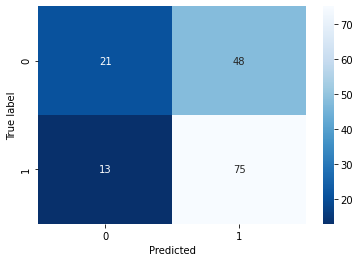

In [72]:
all_num_col_names = ['energy_feed_unit', 'crude_protein', 'fat_content', 'protein', 'sugar_protein_ratio']
all_cat_col_names = ['breed', 'pasture_type', 'breed_of_dad_cow', 'age', 'name_of_dad_cow']

# заменим категориальные значения столбца с целевым признаком на числовое выражение
ferma_main['milk_taste'] = ferma_main['milk_taste'].replace({'вкусно': 1, 'не вкусно': 0})

ferma_main['milk_taste']

df_1_for_logic_reg_results_of_def = learning_logical_reg_model(
    ferma_main[['energy_feed_unit', 'crude_protein', 'fat_content', 'protein', 'sugar_protein_ratio', 'breed', 'pasture_type', 'breed_of_dad_cow', 'age', 'name_of_dad_cow']],
    ferma_main['milk_taste'],
    all_num_col_names,
    all_cat_col_names)

### 6.2 Оценка качества полученной модели и ее корректировка

Т.к. в приоритете, чтобы фермер приобрел только коров с вкусным молоком, нужно снизить риск и минимизировать ошибки, когда модель маркирует корову как дающую вкусное молоко, когда это не так. 

Для этого нам подойдет оценка параметра Precision - отношение верно определенных коров с вкусным молоком к отношению всех коров, которые модель указала как дающих вкусное молоко. Лучше упустить некоторых коров с вкусным молоком, чем ошибочно порекомендовать фермеру коров с невкусным молоком.

На текущий момент этот показатель равен 60% - показатель низкий, необходимо его повысить для рекомендации фермеру коров с действительно вкусным молоком. 

Проверим показатели оценки модели для разных порогов:

In [73]:
columns = []
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=10, endpoint=False)]

# Создание DataFrame из y_test и добавление столбца с вероятностями
data = pd.DataFrame({'y_test': df_1_for_logic_reg_results_of_def.iloc[0]['y_test'],
                     'y_proba': df_1_for_logic_reg_results_of_def.iloc[0]['y_proba'][:, 1]})

data_of_parameters_logic_model = pd.DataFrame(columns=['Threshold', 'Accuracity', 'Recall', 'Precision'])

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    
    # Пересчет показателей для порога
    accuracity = accuracy_score(data['y_test'], data['y_pred_'+str(i)])
    recall = recall_score(data['y_test'], data['y_pred_'+str(i)])
    precision = precision_score(data['y_test'], data['y_pred_'+str(i)])
    
    data_of_parameters_logic_model.loc[len(data_of_parameters_logic_model)] = [
        i,
        accuracity,
        recall,
        precision
    ]
    
    
data_of_parameters_logic_model

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Threshold,Accuracity,Recall,Precision
0,0.10,0.560510,1.000000,0.560510
1,0.19,0.560510,1.000000,0.560510
2,0.28,0.573248,1.000000,0.567742
3,0.37,0.585987,0.977273,0.577181
4,0.46,0.611465,0.909091,0.601504
5,0.55,0.624204,0.772727,0.635514
6,0.64,0.611465,0.568182,0.684932
7,0.73,0.573248,0.340909,0.769231
8,0.82,0.445860,0.011364,1.000000
9,0.91,0.439490,0.000000,0.000000


Используем порог 0.73 для прогнозирования, т.к. при этом пороге значений наиболее оптимальный Precision (равен 0.77), но учтена погрешность, чтобы не был слишком ограничен выбор из коров - да, модель укажет меньшее количество коров из тех, что действительно дают вкусное молоко, но с большой вероятностью они действительно будут приносить его вкусным. 

Повторно построим матрицу ошибок с новым порогом:

Матрица ошибок (после корректировки порога):


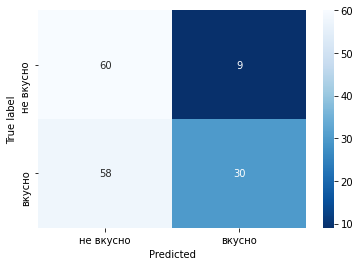

In [74]:
print('Матрица ошибок (после корректировки порога):')
cm = confusion_matrix(data['y_test'], data['y_pred_0.73'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=['не вкусно', 'вкусно'], yticklabels=['не вкусно', 'вкусно'])
plt.ylabel('True label')
plt.xlabel('Predicted')

plt.show()

Таким образом будут точно приобретены все коровы, дающие вкусное молоко, несмотря на приобретение коров, которые дают невкусное. В нашем случае, данный вариант оптимален.

### 6.3 Прогноз вкуса молока

Выведем список столбцов, которые используем как входные данные:

In [75]:
df_1_for_logic_reg_results_of_def.iloc[0]['combination']

['energy_feed_unit',
 'crude_protein',
 'fat_content',
 'protein',
 'sugar_protein_ratio',
 'breed',
 'pasture_type',
 'breed_of_dad_cow',
 'age',
 'name_of_dad_cow']

Перед началом прогноза, дополним недостающие данные в **cow_buy** - для для количественных данных возьмем средние значения из **ferma_main** и добавим 5% сверху. А также преобразуем количественные и категориальные данные.

In [76]:
cow_buy_completed = cow_buy

cow_buy_completed['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean() * 1.05
cow_buy_completed['crude_protein'] = ferma_main['crude_protein'].mean() * 1.05
cow_buy_completed['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05

cow_buy_completed = cow_buy_completed[['energy_feed_unit', 
                                       'crude_protein', 
                                       'fat_content', 'protein', 
                                       'sugar_protein_ratio',
                                       'breed', 'pasture_type',
                                       'breed_of_dad_cow', 'age',
                                       'name_of_dad_cow']]

# Первые строки cow_buy (cow_buy_completed) после дополнения
cow_buy_completed.head()

,energy_feed_unit,crude_protein,fat_content,protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad_cow,age,name_of_dad_cow
0,15.276162,2019.947532,3.58,3.076,0.958744,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,более_2_лет,Геркулес
1,15.276162,2019.947532,3.54,3.081,0.958744,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,менее_2_лет,Буйный
2,15.276162,2019.947532,3.59,3.074,0.958744,Рефлешн Соверинг,Равнинное,Рефлешн Соверинг,более_2_лет,Барин
3,15.276162,2019.947532,3.40,3.061,0.958744,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,более_2_лет,Буйный
4,15.276162,2019.947532,3.64,3.074,0.958744,Рефлешн Соверинг,Равнинное,Вис Бик Айдиал,более_2_лет,Буйный


Подготовим данные для прогноза и спрогнозируем:

In [77]:
RANDOM_STATE = 42

# Объявляем список для столбцов с количественным признаком
num_col_names = ['energy_feed_unit', 'crude_protein', 'fat_content', 'protein', 'sugar_protein_ratio']
# Объявляем список для столбцов с категориальным признаком
cat_col_names = ['breed', 'pasture_type', 'breed_of_dad_cow', 'age', 'name_of_dad_cow']

scaler = df_1_for_logic_reg_results_of_def.iloc[0]['scaler']

# Мастштабирование количественных признаков тестовой выборки
cow_buy_completed_scaled = scaler.transform(cow_buy_completed[num_col_names])

# Приведем полученные данные к типу DataFrame
cow_buy_completed_scaled = pd.DataFrame(cow_buy_completed_scaled, columns=num_col_names)


encoder = df_1_for_logic_reg_results_of_def.iloc[0]['encoder']

# Кодирование категориальных признаков тренировочной выборки
cow_buy_completed_ohe = encoder.transform(cow_buy_completed[cat_col_names])

# Приведем полученные данные к типу DataFrame
encoder_col_names = list(encoder.get_feature_names())
try:
    cow_buy_completed_ohe = pd.DataFrame(cow_buy_completed_ohe.toarray(), columns=encoder_col_names)
except:
    cow_buy_completed_ohe = pd.DataFrame(cow_buy_completed_ohe, columns=encoder_col_names)


# Объединяем обработанные выборки для количественного и категориального признака
cow_buy_completed = pd.concat([cow_buy_completed_scaled, cow_buy_completed_ohe], axis=1)

# Инициализацияя модели линейной регрессии
model_clf = df_1_for_logic_reg_results_of_def.iloc[0]['model_as_logical_regression']

# Получение предсказания модели на тестовых данных 
#final_predictions = model_clf.predict(cow_buy_completed)
probabilities = model_clf.predict_proba(cow_buy_completed)

threshold = 0.73
final_predictions = (probabilities[:, 1] > threshold).astype(int)

final_predictions

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0])

Добавим столбец с прогнозным вкусом молока в **cow_buy** и выведем список коров, где молоко вкусное:

In [78]:
cow_buy['milk_taste_predictable'] = final_predictions
cow_buy['milk_taste_predictable'] = cow_buy['milk_taste_predictable'].replace({1: 'вкусно', 0: 'не вкусно'})

cow_buy.loc[cow_buy['milk_taste_predictable'] == 'вкусно']

,breed,pasture_type,breed_of_dad_cow,name_of_dad_cow,fat_content,protein,age,energy_feed_unit,crude_protein,sugar_protein_ratio,energy_feed_unit_to_square,sugar_protein_ratio_upper_91_procent,milk_yield_predictable,milk_taste_predictable
0,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6491.523471,вкусно
1,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6077.084750,вкусно
7,Вис Бик Айдиал,Равнинное,Рефлешн Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6359.744440,вкусно
9,Рефлешн Соверинг,Холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6169.817682,вкусно
13,Вис Бик Айдиал,Холмистое,Рефлешн Соверинг,Барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,5923.576288,вкусно
16,Вис Бик Айдиал,Холмистое,Рефлешн Соверинг,Соловчик,3.73,3.079,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6236.967532,вкусно


***Под данный критерий подходят 6 коров.***

## 7. Итоговые выводы

Выведем список коров, которые имеют удой свыше 6395 кг (учтем доверительный интервал модели)  и их молоко вкусное:

In [79]:
cow_buy.loc[(cow_buy['milk_yield_predictable'] >= 6395) & (cow_buy['milk_taste_predictable'] == 'вкусно')]

,breed,pasture_type,breed_of_dad_cow,name_of_dad_cow,fat_content,protein,age,energy_feed_unit,crude_protein,sugar_protein_ratio,energy_feed_unit_to_square,sugar_protein_ratio_upper_91_procent,milk_yield_predictable,milk_taste_predictable
0,Вис Бик Айдиал,Холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,0.876507,0.618631,6491.523471,вкусно


**В рамках проекта было выполнено:** 

**1. Загрузка данных о коровах и их молоке из:** 

* ferma_main.csv - данные о стаде фермера, обратившегося за разработкой моделей прогноза; 
* ferma_dad.csv - данные об имени папы каждой коровы в стаде фермера; 
* cow_buy.csv - данные о коровах, из числа которых планируется отобрать и приобретение. 



**2. Предобработка данных:** 

2.1) скорректирован формат наименований столбцов (к стилю snake_case);

2.2) проверка типов данных в столбцах - данные имеют корректный тип; 

2.3) проверка наличия пропусков - пропуски не обнаружены; 

2.4) проведена проверка дубликатов: 
* приведены к одному виду неявные дубликаты в столбцах: 
    * 'breed','breed_of_dad_cow', 'pasture_type'.



**3.  Статистический анализ данных:** 

3.1) проанализировано текущее стадо фермера на основании ferma_main; 

3.2) проанализированы данные об именах пап-быков каждой коровы в стаде фермера ferma_dad; 

3.3) проанализированы данные о коровах на основании cow_buy; 

3.4) описаны оценки данных и план по их улучшению: 


 


**4. Корреляционный анализ (данных из файла ferma_main.csv):** 

4.1) оценка корреляции между признаками и проверка мультиколлинеарности;

    Наибольшее влияние на удой оказывают: 
       * энергетическая кормовая единица корма, 
       * сахаро-протеиновое соотношение в корме, 
       * возраст. 
   
    Мультиколлинеарности между будущими входными признаками при прогнозировании объема удоя не наблюдается. 

    При прогнозировании вкуса молока необходимо будет исключить 'milk_yield' ('Удой, кг') для исключения неустойчивости модели.
    

4.2) Построение диаграмм рассеивания для массы молока, которую корова даёт в год, и других признаков; 

4.3) Выводы о взаимосвязи признаков:

    * Наибольшее влияние на удой оказывают: 
   
        * энергетическая кормовая единица корма, 
        * сахаро-протеиновое соотношение в корме, 
        * возраст. 
   
    * Мультиколлинеарности между будущими входными признаками при прогнозировании объема удоя не наблюдается. 

    * При прогнозировании вкуса молока необходимо будет исключить 'milk_yield' ('Удой, кг') для исключения неустойчивости модели.



**5. Задача регрессии - прогноз объема молока:** 

5.1) обучение первой модели: 

    * R^2 (коэффициент детерминации) = 0.78
    * MSE (среднеквадратичная ошибка) = 43887
    * RMSE (корень из средней квадратической ошибки) = 209
    * MAE (средняя абсолютная ошибка) = 164
    
5.2) обучение второй модели: 

    * R^2 (коэффициент детерминации) = 0.79
    * MSE (среднеквадратичная ошибка) = 43532
    * RMSE (корень из средней квадратической ошибки) = 209
    * MAE (средняя абсолютная ошибка) = 167

5.3) обучение третьей модели: 

    * R^2 (коэффициент детерминации) = 0.80
    * MSE (среднеквадратичная ошибка) = 39907
    * RMSE (корень из средней квадратической ошибки) = 200
    * MAE (средняя абсолютная ошибка) = 163 

5.4) сравнение качества моделей по показателям: 

    Выбрана модель №3 как наиболее оптимальная по показателям и графикам.
    
5.5) прогноз удоя коров: 

    *Под критерий "удой свыше 6000 кг молока за год" подходят все коровы.*
    
    
**6. Задача классификации - прогноз вкуса молока:**

6.1) обучение модели: 
    
    * Accuracity (Точность) = 0.61
    * Recall (полнота) = 0.85
    * Precision (точность предсказаний) = 0.61

6.2) оценка качества полученной модели и ее корректировка: 

    Переопределен порог для прогнозирования для повышения Precision (точности предсказаний) (0.76 для тренировочной выборки), чтобы модель минимально ошибалась, рекомендуя коров с невкусным молоком. Новый порог = 0.73.
    
6.3) Прогноз вкуса молока: 

    *Под критерий "молоко вкусное" подходят 6 коров.*

**7. Итоги и рекомендации:** 

* для обучения и повышения качества модели осуществлялась очистка данных от выбросов, стандартизация признаков, приведение категориальных признаков к числовому выражению, создание новых признаков, отбор наиболее значимых признаков. 
* улучшение результатов моделей возможно, есливозможно собрать больше входных данных или улучшить качество существующих.Также может помочь применение более сложных моделей для прогнозирования. Если текущие данные полные и дополнительно ничего не получить, а также модель является оптимальной, то качество прогноза улучшить не удастся. 
* При оценке линейной регрессионной модели важны признаки: R^2 (Коэффициент детерминации), MSE (Средний квадрат ошибок), RMSE (Корень из среднего квадрата ошибок), MAE (Средняя абсолютная ошибка), также важна гистограмма остатков, диаграмма дисперсии разброса остатков и диаграмма распределения остатков. 
* При оценке логической регрессионной модели важны признаки: Accuracity (точность оценки), Recall (Полнота), Precision (Точность), также важна матрица ошибок. 

Фермеру рекомендуется приобрести одну корову у компании для минимизации рисков, но если требуется больше коров, то можно пренебречь доверительный интервал и выбрать коров с спрогнозированным удоем свыше 6000 кг (а не свыше 6395 кг), но это повысит риск. Для минимиации рисков по приобретению коров с вкусным молоком мы изменили порог вхождения, а также лучшили модель, чтобы фермер наибольшее число коров с вкусным молоком. 